# Final Capstone - Kristofer Schobert

## Forecasting Bike Rebalancing at the Bike Sharing Company: Citi Bike

### Introduction

In this capstone report, we will investigate the rebalancing of bikes at Citi Bike, a bike sharing company in New York, NY. Citi Bike has roughly 800 stations throughout New York City. A customer of Citi Bike may pick up a bike at any station and ride it to any other station. Thus, these bikes flow all around the city. Our question concerns the flow of bikes into and out of each station. Is the flow of bikes into a given station always equal to the flow out? In general, the answer is no. There will be some stations where the average flow of bikes inward is greater and others where the average flow of bikes outward is greater. After enough time has elapsed, some stations will have no bikes left (those with greater outward flow), while others have no empty docks to park a bike (those with greater inward flow). When this happens, manual rebalancing of bikes is needed. Citi Bike hires workers to drive a truck to stations with a bike surplus and transport the bikes to stations with a bike deficit. 

### Our Goal

If Citi Bike is able to predict their stations' change in bike count, they can anticipate their need for this rebalancing work. The cost of sending out the dispatch team can be weighted against the need to rebalance based on these predictions. These workers can be informed of their duties in a timely manner, and the details of the truck's rebalancing route can be planned effectively. As a proof of concept, we will attempt to forecast the change in bike count for three of Citi Bike stations. More specifically, we seek to predict the change in bike count over 24 hour periods for these stations. Since Citi Bike is likely to have the dispatch team work during the night when the traffic is minimal, we will attempt to predict the difference in bike count from one day at midnight to the next. 

### Our Method

We will use two different methods to predict the 24-hour change in bike count for these stations. First, we will use seasonal autoregressive integrated moving average (SARIMA) models to forecast these changes in bike count for the first two weeks of May 2019. We will do this by training our SARIMA models on the known values of this quantity during March and April of 2019. The optimal model will be chosen based on the model's Akaike information criterion (AIC) during the training period. The three models with the best AIC will then be compared via time series nested cross validation on the training data. The model with the best performance will be the one to predict on the testing data. 

Second, we will use regression to predict the expected change in bike count for our testing data. One would expect the weather, day of week or time of year to influence the behavior of Citi Bike users. When performing ARIMA time series analysis, one cannot include all these features. Thus, we will treat our problem with regression. Each instance will represent one day, our target variable will be the change in bike count that day, and our features will include weather data, day of week and month of year. By using cross validation, we will determine the optimal parameters for Random Forest Regression and KNN Regression. The mean squared error will be our metric for determining the optimal model. The training data for the regression will be Citi Bike trip data from January 2017 to April 2019, and we will be predicting the data from the month of May 2019. 

Lastly, we will compare the time series and regression model results. The winning model for each station will be used to predict the rebalancing needs for Citi Bike. We will discuss a model scenario where Citi Bike does not need to rebalance, and another where Citi Bike does need to rebalance. In doing this, we will have synthesised an end-to-end data science solution. 

### Our Data

Citi Bike releases data on all of the trips taken each month. They give the start and end time of the trip as well as start and end stations. We don’t have the number of bikes at a given dock at a given time unfortunately, only the data on the trips. Thankfully, our method relies on the change in bike count rather than the number of bikes at a station. One main assumption we have with our data is that Citi Bike has been rebalancing their stations well. We assume the trips taken from a station is a reflection of the demand of the users at that station. If a station is left empty by Citi Bike, it will seem as though users did not want to take a bike from that station.

The weather data we will incorporate into our regression models will come from the National Oceanic and Atmospheric Administration's website where we can download past weather data collected at the John F. Kennedy International Airport in New York, NY. 

Citi Bike trip data: https://s3.amazonaws.com/tripdata/index.html

New York City weather data: https://www.ncdc.noaa.gov/cdo-web/search


In [1]:
# importing packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from collections import Counter
import glob
from pmdarima.arima import auto_arima
import pmdarima
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
import statsmodels as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import scale

We will begin by importing the trip data collected from Citi Bike's website. We will be training our models on the March and April data and predicting on the May data. 

In [2]:
# Importing the data from March, April and May of 2019
df_march = pd.read_csv('Citi_Bike/201903-citibike-tripdata.csv')
df_april = pd.read_csv('Citi_Bike/201904-citibike-tripdata.csv')
df_may = pd.read_csv('Citi_Bike/201905-citibike-tripdata.csv')

We will now be splitting our data into testing and testing plus training data. Please note that df_main includes both as a means of making our analysis and predictive functions more streamlined. 

In [3]:
# Combining those dataframes into our training and training plus testing dataframes
df_train = pd.concat([df_march, df_april], axis=0, ignore_index=True)
df_main = pd.concat([df_march, df_april, df_may], axis=0, ignore_index=True)

Here are a few rows of our data. We have a fair amount of data on each trip taken by Citi Bike users. We have the duration of the trip in seconds, the start and stop time of the trip expressed in the local time zone, the name, I.D. and coordinates of the starting and ending station, the bike's I.D., whether the user is a long-term subscriber (e.g. annual plan) or a short-term customer (purchased one trip only), the user's birth year and their gender (1 = male, 2 = female, 0 = prefer to not answer).

We are interested in analyzing the flow of bikes into and out of one station. Thus, much of these columns will be ignored. We only need 'starttime', 'stoptime', 'start station id', 'end station id', 'start station name' and 'end station name'. The other columns will soon be dropped.


In [4]:
df_train.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1463,2019-03-01 00:00:16.0970,2019-03-01 00:24:39.3880,319.0,Fulton St & Broadway,40.711066,-74.009447,347.0,Greenwich St & W Houston St,40.728846,-74.008591,35618,Subscriber,1989,1
1,285,2019-03-01 00:00:32.3850,2019-03-01 00:05:18.1830,439.0,E 4 St & 2 Ave,40.726281,-73.989780,150.0,E 2 St & Avenue C,40.720874,-73.980858,31113,Subscriber,1980,1
2,686,2019-03-01 00:00:47.7970,2019-03-01 00:12:14.3090,526.0,E 33 St & 5 Ave,40.747659,-73.984907,3474.0,6 Ave & Spring St,40.725256,-74.004121,19617,Subscriber,1987,1
3,442,2019-03-01 00:01:01.2090,2019-03-01 00:08:23.7510,3474.0,6 Ave & Spring St,40.725256,-74.004121,355.0,Bayard St & Baxter St,40.716021,-73.999744,27086,Subscriber,1987,2
4,2913,2019-03-01 00:01:09.2810,2019-03-01 00:49:42.3810,379.0,W 31 St & 7 Ave,40.749156,-73.991600,212.0,W 16 St & The High Line,40.743349,-74.006818,34791,Subscriber,1991,1


We will now create a list of the most common starting stations in descending order (most common is first). We will also create a dictionary that will link a station's ID with the station's name - 'start station id' being key and 'start station name' being the value. 

In [5]:
# Determining the number of stations
number_of_stations = df_train[df_train['start station id'].notnull()][
    'start station id'].nunique() 
print(
    'During March 2019 and April 2019 trips began at {} unique stations.'.format(
    number_of_stations) + 
      ' There may be other stations that individuals did not use.')

# Creating a list of the most common starting stations in descending order
common_starting_stations = []
for tup in Counter(df_train[df_train['start station id'].notnull()][
    'start station id']).most_common(
    number_of_stations):
    common_starting_stations.append(tup[0])
    
# Creating a dictionary relating a stations id to its name    
common_starting_stations_dict = {}
for station in common_starting_stations:
    common_starting_stations_dict[station] = list(
        df_train[df_train['start station id'] == station][
            'start station name'])[0]


During March 2019 and April 2019 trips began at 790 unique stations. There may be other stations that individuals did not use.


We will now begin synthesizing our trip data to make our time series for each station. The value of this time series will be the number of arrivals minus the number of departures at our station since midnight on March 1st, 2019. We will execute this by creating a dataframe that consists of trips that are taken to or from our station of interest. In this new dataframe, we will create a column, 'arrive_depart', that will have a value of +1 for an arrival, -1 for a departure, and 0 for a round trip. This way we can sum the values of arrive_depart for a given day and determin the net change in bike count over a 24 hour period. We can also coninually add the values of 'arrive_depart' to determine if our station loses bikes more often than it gains bikes, or vise versa. We can then answer the question, "Will this station be facing a bike deficit, a surplus, or will this station be naturally well balanced?"

In [6]:
def create_station_dataframe(station_id, df):
    """
    Creates a dataframe of trips to and from the selected station.
    
    Parameters:
    station_id (int): the station of interest's I.D. number
    df (pandas dataframe): the dataframe provided by Citi Bike
    
    Returns:
    station (pandas df): dataframe of trips to and from the selected station
    
    """
    
    # Selecting all rows concerning our station
    station = df[(df['start station id'] == station_id) |
                 (df['end station id'] == station_id)].copy()

    # Dropping unnecessary columns
    station = station.drop(['tripduration', 'start station latitude',
           'start station longitude', 'end station latitude', 
           'end station longitude', 'bikeid', 'usertype', 'birth year', 'gender'], 
                           axis = 1)
    
    
    # Adding column arrive_depart. This is 1 if the trip adds a bike to this station
    # It is -1 if the bike leaves the station and 0 if it is a round trip.

    conditions = [
        (station['start station id'] == station_id) & (station[
            'end station id'] != station_id),
        (station['end station id'] == station_id) & (station[
            'start station id'] != station_id),
        (station['start station id'] == station_id) & (station[
            'end station id'] == station_id)]
    choices = [-1, 1, 0]
    station['arrive_depart'] = np.select(conditions, choices)

    station = station.reset_index()
    station = station.drop(['index'], axis = 1)

    # converting times to datetime format
    station['starttime'] = pd.to_datetime(station['starttime'])
    station['stoptime'] = pd.to_datetime(station['stoptime'])

    # Tallying the 'arrive_depart' values to obtain a running total
    list_total_arrive_depart = []
    list_total_arrive_depart.append(station['arrive_depart'][0])
    for index in range(1, len(station['arrive_depart'])):
        list_total_arrive_depart.append(list_total_arrive_depart[
            index - 1] + station['arrive_depart'][index])
    station['total_arrive_depart'] = list_total_arrive_depart
    
    return station

In [7]:
# Showing dataframe for the 4th most common starting station
station_rank = 4
frame = create_station_dataframe(common_starting_stations[station_rank -1],
                                 df_train)
print('''Dataframe containing trip data for {}, 
the fourth most frequented station.'''.format(common_starting_stations_dict[
    common_starting_stations[station_rank -1]]))
frame.head()

Dataframe containing trip data for E 17 St & Broadway, 
the fourth most frequented station.


,starttime,stoptime,start station id,start station name,end station id,end station name,arrive_depart,total_arrive_depart
0,2019-03-01 05:12:41.608,2019-03-01 05:27:07.540,342.0,Columbia St & Rivington St,497.0,E 17 St & Broadway,1,1
1,2019-03-01 06:16:04.964,2019-03-01 06:20:43.263,446.0,W 24 St & 7 Ave,497.0,E 17 St & Broadway,1,2
2,2019-03-01 06:08:36.469,2019-03-01 06:15:52.851,497.0,E 17 St & Broadway,3427.0,Lafayette St & Jersey St,-1,1
3,2019-03-01 06:42:13.258,2019-03-01 06:46:29.974,2003.0,1 Ave & E 18 St,497.0,E 17 St & Broadway,1,2
4,2019-03-01 06:47:49.276,2019-03-01 06:49:56.101,3463.0,E 16 St & Irving Pl,497.0,E 17 St & Broadway,1,3


Here we have the dataframe for E 17 St & Broadway. We have chosen to inspect this station because of it's more clear demonstration of 'total_arrive_depart'. Again, this column is the running total of 'arrive_depart'. 

Now let's look at the function of arrive_depart versus time for a few stations.

In [8]:
def plot_time_series(station_id, df):
    """
    Plots the continuous time series for a station
    
    Parameters:
    station_id (int): the station of interest's I.D. number
    df (pandas dataframe): the dataframe provided by Citi Bike
    
    """
    
    station = create_station_dataframe(station_id, df)
    station = station.sort_values(by=['starttime'])
    plt.figure(figsize = (20,5))
    plt.plot(station['starttime'], station['total_arrive_depart'])
    plt.title('Running Total of Arrivals Minus Departures at Station {}\n{}'.format(
        int(station_id), common_starting_stations_dict[station_id]))
    plt.xticks(rotation = 30)
    plt.show()    


/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


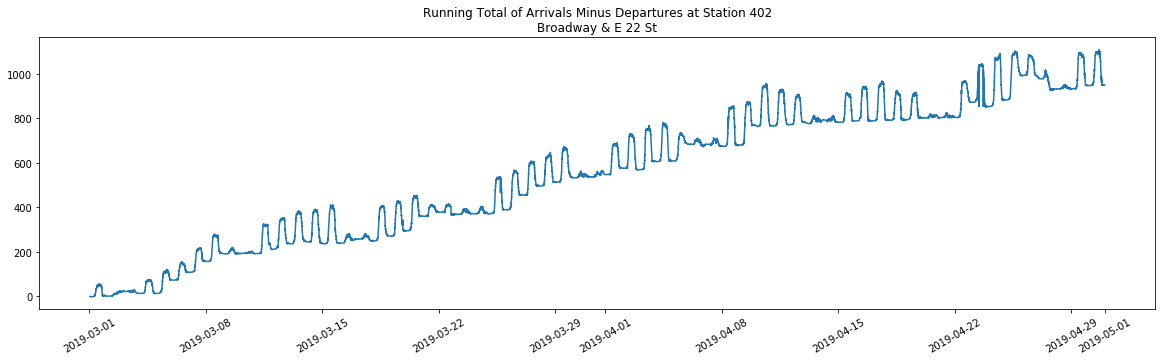

In [9]:
# plotting time series for Broadway & E 22 St
plot_time_series(common_starting_stations[1], df_train)

We see some very interesting patterns at the second most frequented station, Broadway & E 22 Street. For one there seems to be both daily and weekly periodic trends in this data. People generally arrive at the station in the morning and leave in the evening. There seems to be some grouping of the peaks which must be attributed to the different behaviors of users during weekdays and weekends. Also, we see that this station at Broadway & E 22 St experiences a surplus of bikes. After two months have past we have roughly 1000 more arrivals than departures. This tells us that Citi bike must have removed bikes from this station and brought them to stations where there was a bike deficit. Let's look at a few more station's timeseries.

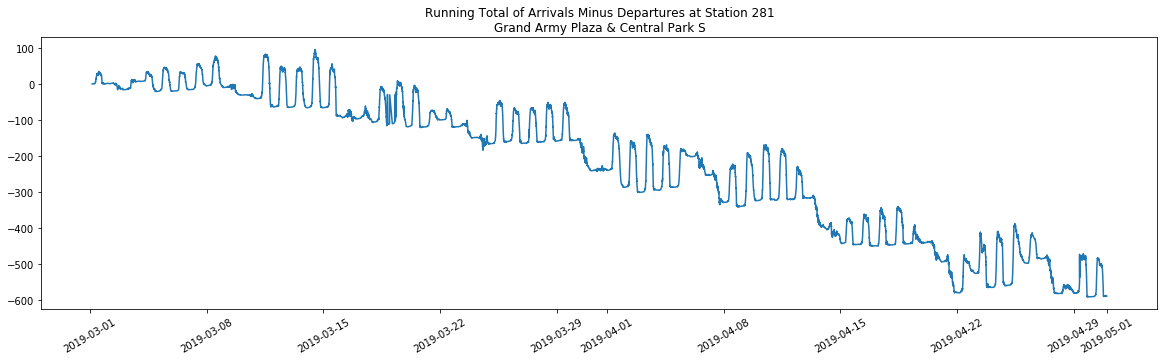

In [10]:
# Grand Army Plaza & Central Park S
plot_time_series(281, df_train)

Here we see a station a bike deficit issue. People often start trips at this station, but end their trips here much less often. Thus, Citi Bike will often face having no bikes at this station, which is very bad for business. Citi Bike must be sure to keep this station well stocked. We will model this station in hopes of predicting how many bikes one should expect to lose each day. 

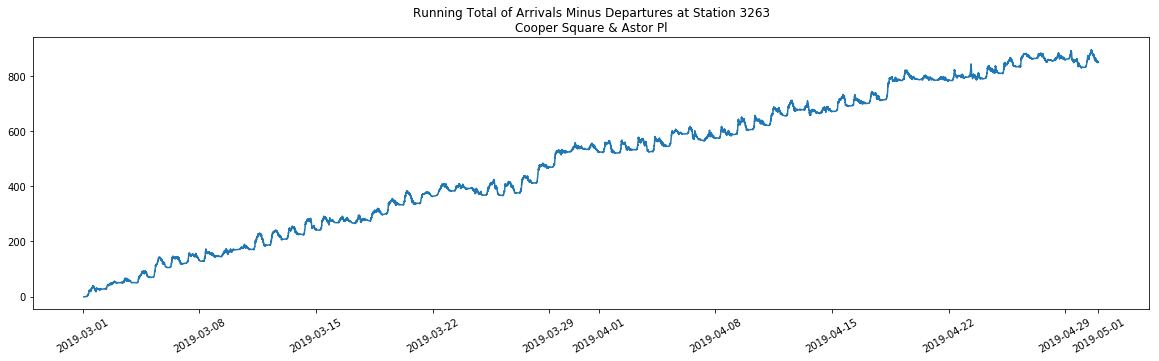

In [11]:
# Cooper Square & Astor Pl
plot_time_series(3263, df_train)

The station at Cooper Square & Astor Pl experiences a large surplus issue. This station also has a fairly regular timeseries. When we use ARIMA modeling to predict future changes in bike count, we will need to predict on stations with stationary time series because that is one of the requirements of ARIMA modeling. A time series that is stationary has a constant mean and constant varience. While this time series is increasing, it is doing so at a constant rate, thus the change in bike count per day will be stationary. This model is a great candidate because it has a severe surplus issue and it is stationary. We will model it.  

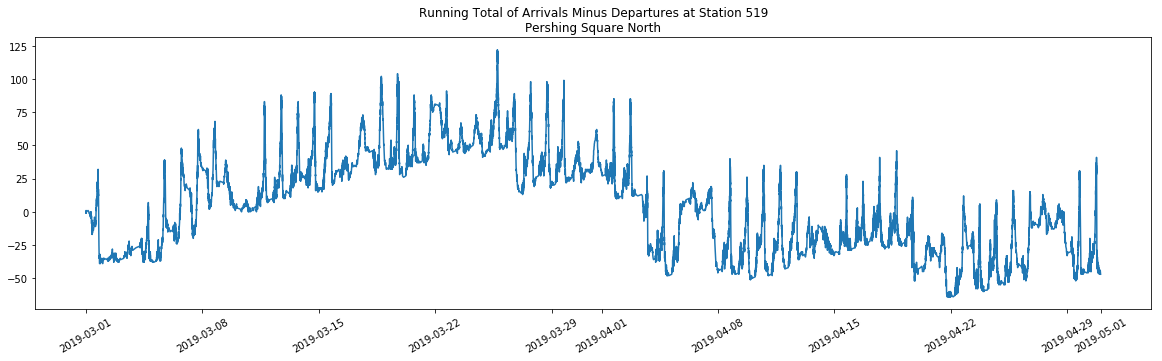

In [12]:
# Pershing Square North
plot_time_series(common_starting_stations[0], df_train)

Here is the most frequented station, Pershine Square North. This station has a time series that is not stationary. We can see this via the arch followed by flatness. Thus an ARIMA model is not suited for predicting on this station. Fortunately for us and Citi Bike, it does not seem to have much of a rebalancing problem. We will also be using regression to predict the change in bike count per day. We could model this station with that method, however we will not because it is naturally well balanced. 

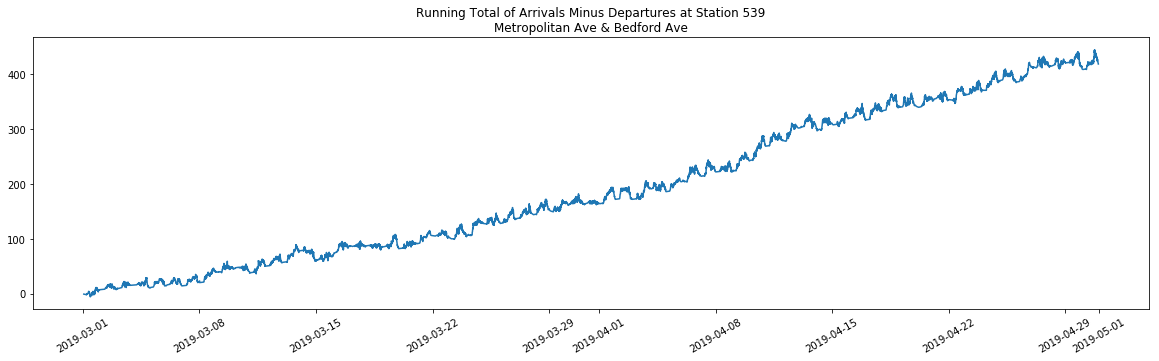

In [13]:
# Metroolitian Ave & Bedford Ave
plot_time_series(539, df_train)

This Brooklyn station at Metroolitian Ave & Bedford Ave has a moderate rebalancing issue, looks stationary, and looks a bit noisy. This seems to be an interesting station to model and we will do so.

The three stations we will be modeling are Grand Army Plaze & Central Park S, Cooper Square & Astor Pl, and Metropolitian Ave & Bedford Ave. That is station 391, 3263 and 539 respectively. They all have a time series that is both stationary and shows a moderate to serious rebalancing issue.  

## ARIMA Forecasting

First, we will define the functions that make our modeling and forecasting more streamline. 

In [11]:
################################################################################
def create_station_daily_dataframe(station_id, station_df):
    """
    Creates a dataframe with the summed value of arrivals minus departues 
    for each day. In this data frame each row represents on day.
    
    Parameters:
    station_id (int): the station id number
    station_df (pandas df): the dataframe of trip pertaining to the station
    
    Returns:
    station_daily_df (pandas df): dataframe with the summed value of arrivals minus 
                                departues for each day as well as the 
                                running total of that value
    """
    
    
    # Creating columns for year month and day
    # Being aware the subtleties in timing 
    # When a bike leaves the station the start trip time is the time of interest
    # When a bike arrives at the station the end trip time is the time of interest
    # For round trips we will use the start time. 
    station_df['year'] = np.where(station_df['start station id'] == station_id, 
                               station_df['starttime'].dt.year,
                                  station_df['stoptime'].dt.year)
    station_df['month'] = np.where(station_df['start station id'] == station_id, 
                               station_df['starttime'].dt.month,
                                   station_df['stoptime'].dt.month)
    station_df['day'] = np.where(station_df['start station id'] == station_id, 
                               station_df['starttime'].dt.day,
                                 station_df['stoptime'].dt.day)

    # Creating dataframe which will consolidate data regarding daily changes 
    # in bike count
    # Here we are summing all the 1s, 0s, and -1s for all trips during a given day
    station_daily_df = pd.pivot_table(station_df, values='arrive_depart', 
                                   index=['year','month', 'day'], aggfunc=np.sum, 
                                   fill_value=0).reset_index()

    # Renaming column now that it contains summed change in bike count per day
    station_daily_df = station_daily_df.rename({'arrive_depart': 'change_per_day'},
                                               axis=1)

    # Creating date column which is a datetime object
    station_daily_df['date'] = pd.to_datetime(
        station_daily_df[['year','month','day']])

    # Creating a column for the total change from the beginning of the timeseries
    # This is a running total of change in bikes for the given station since the
    # start of the timeseries, rather than the change per day
    # It is similar to arrive_depart used earlier but instead this groups by day
    list_sum_of_change = []
    list_sum_of_change.append(station_daily_df['change_per_day'][0])
    for index in range(1, len(station_daily_df)):
        list_sum_of_change.append(
            list_sum_of_change[index - 1] + station_daily_df['change_per_day'][index])
    station_daily_df['total_change'] = list_sum_of_change
    
    station_daily_df = station_daily_df.drop(['year','month','day'], axis=1)
    
    return station_daily_df

In [14]:
def create_station_series_full(station_daily_df):
    """
    Creates a time series for the station with arrivals minus departures
    as the value of the time series. One day is the time step and it is the 
    index of the series.
    
    Parameters:
    station_daily_df (Pandas df): dataframe with the summed value of arrivals minus 
                                departues for each day as well as the 
                                running total of that value. This is to include both
                                the training and testing time period
    Returns:
    station_series_full (Pandas series): The station's change in bike count 
                                        for the day is the value, and the day 
                                        is the index
    
    """
    return pd.Series(list(station_daily_df['change_per_day']),
                           index = station_daily_df['date'])




def create_series_train(station_series_full, first_testing_date):
    
    """
    Creates the training time series for the station with arrivals minus departures as
    the value and days and the index.
    
    Parameters:
    station_series_full (Pandas series): The station's change in bike count 
                                        for the day is the value, and the day 
                                        is the index
    first_testing_date (str): The first date that will be in the testing dataset.
                            Note that the format of this must be 'YYYY-MM-DD'
    
    Returns: 
    series_train (Pandas series): The desired time series described above
    """

    series_df = station_series_full.reset_index()
    series_train_df = series_df[series_df['date'] < pd.to_datetime(first_testing_date)]
    series_train = pd.Series(list(series_train_df[0]), index = series_train_df['date'])
    return series_train   

def create_series_train_total_change(station_daily_df, first_testing_date):
    """
    Creates the training time series for the station with tallied arrivals minus 
    departures as the value and days as the index.
    
    Parameters:
    station_series_full (Pandas series): The station's change in bike count 
                                        for the day is the value, and the day 
                                        is the index
    first_testing_date (str): The first date that will be in the testing dataset.
                            Note that the format of this must be 'YYYY-MM-DD'
    
    Returns:
    (Pandas series): The series described above in the function's summary.
    """
    
    
    
    station_daily_df_train = station_daily_df[
        station_daily_df['date'] < pd.to_datetime(first_testing_date)]
    return pd.Series(list(station_daily_df_train['total_change']),
                     index = station_daily_df_train['date'])

In [44]:
def nested_cross_validation_sm(station_series, order_,
                               seasonal_order_,
                               trials,
                               forecast_count,
                               station_id,
                              print_model_summary):
    
    """
    Implements Day Forward-Chaining Nested Cross Validation on the training data.
    Plots the timeseries nested cross validation trial's predictions
    Prints the RMSE and MAE of the validation
    
    Parameters:
    station_series (Pandas series): The training series to perform time series
                                    nested cross validation on
    order_ (str): The order of the SARIMA model. For instance: '(0, 0, 1)'
    seasonal_order_ (str): The seasonal order of the SARIMA model. 
                            Example: '(0, 0, 1, 7)'
    trials (int): The number of trials of nested cross validation
    forecast_count (int): The number of days to forecast during one trial of
                            nested cross validation. After the trial is completed
                            the model will update using these data points and predict
                            the next forecast_count number of data points
    station_id (int): the station of interest's I.D. number
    print_model_summary (Boolean): If True, will print the model's summary given 
                                by statsmodels.
                                
    Returns:
    future_forecast (list of floats): Each predicted forecasts during the nested
                                    cross validation. 
  
    """

    # Using Walk-Forward Validation to calculate the root mean squared error 
    # of our model on the training data

    # Preparing validation plot
    plt.figure(figsize=(15,5))

    future_forecast = []

    # used if forecast_count = 1
    testing_index = []

    # Loop for walk-forward validation
    for trial in range(trials):
        # Using variable to calculate each index for our walk-forward validation
        train = station_series[:-(forecast_count*(trials-trial))]
        # If statment to avoid using 0 as ending index 
        # (e.g my_list[-7:0] is invalid, we need my_list[-7:])
        if -(forecast_count*(trials-trial))+forecast_count != 0:
            test = station_series[-(forecast_count*(trials-trial)):
                                  -(forecast_count*(trials-trial)) + 
                                  forecast_count]
        else:
            test = station_series[-(forecast_count*(trials-trial)):]


        # Fitting the optimal ARIMA model to the data used for
        # this window of the walk forward validation
        train.index = pd.DatetimeIndex(train.index.values,
                                freq='D')       

        # Using statsmodels SARIMAX function
        model = sm.tsa.statespace.sarimax.SARIMAX(train, order=order_,
                                                  seasonal_order=seasonal_order_)
        model_fit = model.fit()
        
    
        # Forecasting
        start_date = pd.to_datetime(train.index[-1]) + timedelta(days=1)
        end_date = start_date + timedelta(days=forecast_count - 1)
        trial_forecast = model_fit.predict(start=start_date,
                          end=end_date)
        for forecast in trial_forecast:
            future_forecast.append(forecast)

        if forecast_count > 1:

        # Plotting the current validation forecast
            plt.plot(test.index, trial_forecast)
        else:
            testing_index.append(test.index)
    if forecast_count == 1: 
        plt.plot(testing_index, future_forecast, label='predictions')
    plt.plot(station_series, label='true_values', color='black')
    plt.xticks(rotation=30)
    plt.title('Nested Cross Validation\n' + 
              common_starting_stations_dict[station_id] +
              '\nChange in Bike Count per Day\n{}x{}'.format(
                  order_,seasonal_order_))
    plt.legend()
    plt.show()

    # Calculating MSE
    error = np.sqrt(mean_squared_error(
        station_series[-len(future_forecast):], future_forecast))
    abs_error = mean_absolute_error(
        station_series[-len(future_forecast):], future_forecast)
    print("Root Mean Squared Error: {:.2f} bikes".format(error))
    print("Mean Absolute Error: {:.2f} bikes".format(abs_error))
    
    if print_model_summary == True:
        station_series.index = pd.DatetimeIndex(station_series.index.values,
                                freq='D')       
                               #freq=train.index.inferred_freq)
        model = sm.tsa.statespace.sarimax.SARIMAX(
            station_series, order=order_, seasonal_order=seasonal_order_)
        model_fit = model.fit()
        print(model_fit.summary())
    
    return future_forecast
      

In [17]:
def time_series_predict_compare_sm(station_series,
                                   order_,
                                   seasonal_order_,
                                   trials,
                                   forecast_count,
                                   first_testing_date,
                                   station_id):
    
    """
    Implements Day Forward-Chaining Nested Cross Validation on the training data.
    Plots the predictions against observation.
    Prints the RMSE and MAE of the validation
    
    Parameters:
    station_series (Pandas series): The combined training and testing time series 
    order_ (str): The order of the SARIMA model. For instance: '(0, 0, 1)'
    seasonal_order_ (str): The seasonal order of the SARIMA model. 
                            Example: '(0, 0, 1, 7)'
    trials (int): The number of trials of prediction
    forecast_count (int): The number of days to forecast during one trial. 
                            After the trial is completed
                            the model will update using these data points and predict
                            the next forecast_count number of data points
    first_testing_date (str): The first date that will be in the testing dataset.
                            Note that the format of this must be 'YYYY-MM-DD'                       
    station_id (int): the station of interest's I.D. number

                                
    Returns:
    future_forecast (list of floats): Each predicted forecasts
  
    """
    
    
    

    # Preparing validation plot
    plt.figure(figsize=(15,5))

    future_forecast = []

    # used if forecast_count = 1
    testing_index = []
    
    # list of true values to compare predictions to
    list_of_true_test_values = []

    first_testing_date_dt = pd.to_datetime(first_testing_date)

    # Loop for each trial of prediction
    for trial in range(trials):
        # Using variable to calculate each index for our walk-forward validation
        train = create_series_train(
            station_series, first_testing_date_dt + timedelta(
                days=trial*forecast_count))
        test = station_series.iloc[len(train):len(train)+forecast_count]

        # Fitting the optimal ARIMA model to the data used for
        # this window of the walk forward validation
        
        train.index = pd.DatetimeIndex(train.index.values,
                                freq='D')       
        
        # model refits for each trial
        model = sm.tsa.statespace.sarimax.SARIMAX(
            train, order=order_, seasonal_order=seasonal_order_)
        model_fit = model.fit()
        
        
        # Forecasting
        start_date = pd.to_datetime(
            first_testing_date) + timedelta(days=forecast_count*trial)
        end_date = start_date + timedelta(days=forecast_count - 1)
        trial_forecast = model_fit.predict(start=start_date,
                          end=end_date, freq='D')

        # appending the list of forcastes to be returned
        for forecast in trial_forecast:
            future_forecast.append(forecast)
            
        # creating the list of true values for error measurement 
        for test_value in test:
            list_of_true_test_values.append(test_value)

        if forecast_count > 1:

        # Plotting the current validation forecast
            plt.plot(test.index, trial_forecast)
        else:
            testing_index.append(test.index)
    if forecast_count == 1: 
        plt.plot(testing_index, future_forecast, label='predictions')
    plt.plot(station_series.iloc[:len(train)+forecast_count],
             label='true_values', color='black')
    plt.xticks(rotation=30)
    plt.title('{}-Day Forecasts\n'.format(forecast_count) + 
              common_starting_stations_dict[station_id] +
              '\nChange in Bike Count per Day')
    plt.legend()
    plt.show()

    # printing metrics
    error = np.sqrt(mean_squared_error(
        list_of_true_test_values, future_forecast))
    abs_error = mean_absolute_error(list_of_true_test_values, future_forecast)
    print("Root Mean Squared Error: {:.2f} bikes".format(error))
    print("Mean Absolute Error: {:.2f} bikes".format(abs_error))

    return future_forecast


In [62]:
################################################################################
def auto_arima_fitting_and_results(station_id, df, 
                          first_testing_date,
                          plot_timeseries, 
                          print_adf, 
                          plot_acf_pacf,
                          fit_with_auto_arima,
                          print_model_summary,
                          validation, 
                          one_day_forecast,
                          multiple_day_forecast,
                          return_forecasts):
    """
    This function begins with the data frame downloaded from Citi Bike's website
    determines the optimal SARIMA model for a given station, predicts on testing 
    data and evaluates the predictions.
    
    
    Using pmdarima's auto_arima function the optimal SARIMA model is found and 
    future predictions can be made. 
    Plots of the Autocorrelation and Partial Autocorrelation are made
    Nested Cross Validation can be done
    One day and multiple day forcasts can be done
    
    Parameters:
    station_id (int): the station of interests ID number
    df (pandas dataframe): Citi Bikes dataframe downloaded from website
    first_testing_date (str): the first testing day 'YYYY-MM-DD'
    plot_timeseries (Boolean): if true, plots both arrivals minus departures and 
                            the running total of this quantity
    print_adf (Boolean): if true, runs an augmented Dickey–Fuller test
    plot_acf_pacf (Boolean): if true, plots the Autocorrelation and Partial 
                            Autocorrelation functions
    fit_with_auto_arima (Boolean): if true, finds the SARIMA model with lowest
                                    AIC values
    print_model_summary (Boolean): if true, print the statsmodels summary of the
                                    SARIMA model
    validation (Boolean): if true, performs nested cross validation on the training
                            data
    one_day_forecast (Boolean): if true, conducts daily forecasts. The model retains
                                after each day. 
    multiple_day_forecast (Boolean): if true, conducts 3-day forecasts. the model
                                    retrains on the perviously forecasted days
                                    after each trial
    return_forecasts (Boolean): if true, returns the models forecasts   
    
    Returns:
    (list of lists of floats): returns a lists of two elements. The first element 
                                is a list of floats that are the 1-day forecasts.
                                The second element is a list of floats that are the
                                3-day forecasts. 
    
    """
    print('Analyzing Station {}\n{}'.format(station_id,
                                            common_starting_stations_dict[station_id]))
    
    # Using create_station_dataframe
    # Creating new dataframe which only include trip to and from our current station
    # Selecting rows, which involve our current station, from the dataframe 
    # containing all Citi Bike trips
    station_df = create_station_dataframe(station_id, df).drop(
        ['total_arrive_depart'], axis=1)

    # create necessary time series data
    station_daily_df = create_station_daily_dataframe(station_id, station_df)
    
    station_series_full = create_station_series_full(station_daily_df)
    
    series_train = create_series_train(station_series_full, first_testing_date)

    series_train_total_change = create_series_train_total_change(
        station_daily_df, first_testing_date)
    
    # plotting the time series data
    if plot_timeseries == True:
        plt.figure(figsize=(15,5))
        plt.plot(series_train_total_change)
        plt.title(
            'Running Total of Arrivals Minus Departures\nGrouped by Day\n{}'.format(
            common_starting_stations_dict[station_id]))
        plt.xticks(rotation = 30)
        plt.show()
        
        plt.figure(figsize=(15,5))
        plt.plot(series_train)
        plt.title('Change in Bike Count per Day\n{}'.format(
            common_starting_stations_dict[station_id]))
        plt.xticks(rotation = 30)
        plt.show()   
    
    
    # run a ADF stationary test
    if print_adf == True:
        
        result = adfuller(series_train)
        print(
            '\nStationary test for arrivals minus departures per day\nat {}'.format(
            common_starting_stations_dict[station_id]))
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('\n')

    # use pmdarima's auto_arima to find the SARIMA function with best AIC    
    if fit_with_auto_arima == True:   
        # Using auto_arima to find the arima model with the lowest (best) AIC score
        model = auto_arima(series_train, start_p=0, start_q=0,
                               max_p=3, max_q=3, m=7, 
                               start_P=0, start_Q=0, max_P = 2, max_Q = 2, 
                               stationary=True, seasonal=True, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True,
                               stepwise=True,
                               information_criterion = 'aic');
        
        print('{} has a model order of {} and a seasonal order of {}'.format(
        common_starting_stations_dict[station_id], model.order, model.seasonal_order))    

    # plots Autocorrelation Function
    if plot_acf_pacf == True:
        pmdarima.utils.plot_acf(series_train, show=False)
        plt.title(common_starting_stations_dict[station_id] +'\nAutocorrelation')
        plt.xlabel('Lag')
        plt.show()
        pmdarima.utils.plot_pacf(series_train, show=False)
        plt.title(
            common_starting_stations_dict[station_id] +'\nPartial Autocorrelation')
        plt.xlim((-.5,25.2))
        plt.ylim((-1.2,1.2))
        plt.xlabel('Lag')
        plt.show()

    # performing nested cross validation
    if validation == True:
        
        cv_results = nested_cross_validation_sm(station_series = series_train,
                                order_ = model.order, 
                                seasonal_order_ = model.seasonal_order,
                                trials = 14, 
                                forecast_count = 1,
                                station_id=station_id,
                                print_model_summary=print_model_summary)



    # performs daily forecasts
    if one_day_forecast == True:

        y_pred_daily = time_series_predict_compare_sm(
            station_series = station_series_full, 
            order_ = model.order, 
            seasonal_order_ = model.seasonal_order,
            trials = 14, 
            forecast_count = 1, 
            first_testing_date = first_testing_date,
            station_id=station_id)

    # performs five 3-day forecasts
    if multiple_day_forecast == True:    
        
        y_pred_multiple_days = time_series_predict_compare_sm(
            station_series = station_series_full, 
            order_ = model.order, 
            seasonal_order_ = model.seasonal_order,
            trials = 5, 
            forecast_count = 3, 
            first_testing_date = first_testing_date,
            station_id=station_id)

    # returns list of lists of forecasts
    if return_forecasts == True:    
        return [y_pred_daily, y_pred_multiple_days]    

In [63]:
################################################################################
def arima_fitting_and_results(station_id, df, order_, seasonal_order_, 
                              first_testing_date, print_model_summary, validation,
                              one_day_forecast, multiple_day_forecast, 
                              return_forecasts):
    
    """
    This function is very similar to the above function: 
    auto_arima_fitting_and_results
    The difference here is that we give the function a SARIMA model we would
    like it to validate and predict with
    
    Parameters:
    station_id (int): the station of interests ID number
    df (pandas dataframe): Citi Bikes dataframe downloaded from website
    order_ (str): The order of the SARIMA model. For instance: '(0, 0, 1)'
    seasonal_order_ (str): The seasonal order of the SARIMA model. 
                            Example: '(0, 0, 1, 7)'
    first_testing_date (str): the first testing day 'YYYY-MM-DD'
    print_model_summary (Boolean): if true, print the statsmodels summary of the
                                    SARIMA model
    validation (Boolean): if true, performs nested cross validation on the training
                            data
    one_day_forecast (Boolean): if true, conducts daily forecasts. The model retains
                                after each day. 
    multiple_day_forecast (Boolean): if true, conducts 3-day forecasts. the model
                                    retrains on the perviously forecasted days
                                    after each trial
    return_forecasts (Boolean): if true, returns the models forecasts   
    
    Returns:
    (list of lists of floats): returns a lists of two elements. The first element 
                                is a list of floats that are the 1-day forecasts.
                                The second element is a list of floats that are the
                                3-day forecasts. 
    
    
    """
    
    
    
    print('Analyzing Station {}\n{}'.format(
        station_id, common_starting_stations_dict[station_id]))
    print('order={}, seasonal_order={}'.format(order_, seasonal_order_))

    # Using create_station_dataframe
    # Creating new dataframe which only include trip to and from our current station
    # Selecting rows, which involve our current station, from the dataframe 
    # containing all Citi Bike trips
    station_df = create_station_dataframe(
        station_id, df).drop(['total_arrive_depart'], axis=1)

    
    station_daily_df = create_station_daily_dataframe(station_id, station_df)
    
    station_series_full = create_station_series_full(station_daily_df)
    
    series_train = create_series_train(station_series_full, first_testing_date)

    series_train_total_change = create_series_train_total_change(
        station_daily_df, first_testing_date)
    
    

        
    # performing nested cross validation   
    if validation == True:
        
        cv_results = nested_cross_validation_sm(
            station_series = series_train,
            order_ = order_,
            seasonal_order_ = seasonal_order_,             
            trials = 14, 
            forecast_count = 1,
            station_id=station_id,
            print_model_summary=print_model_summary )    

    # performing one day time series predictions for the first
    # two weeks of the training data
    # retraining after each prediction
    if one_day_forecast == True:

        y_pred_daily = time_series_predict_compare_sm(
            station_series = station_series_full, 
            order_ = order_,
            seasonal_order_ = seasonal_order_,  
            trials = 14, 
            forecast_count = 1, 
            first_testing_date = first_testing_date,
            station_id=station_id)

    # performing three day time series predictions for the first
    # 15 days of the training data
    # retraining after each prediction
    if multiple_day_forecast == True:    
        
        y_pred_multiple_days = time_series_predict_compare_sm(
            station_series = station_series_full, 
            order_ = order_,
            seasonal_order_ = seasonal_order_, 
            trials = 5, 
            forecast_count = 3, 
            first_testing_date = first_testing_date,
            station_id=station_id)
        
    # returns list of lists of forecast results
    if return_forecasts == True:    
        return [y_pred_daily, y_pred_multiple_days]

## Evaluation of time series models for three stations

We will be using seasonal ARIMA models to model our timeseries. Using pmdarima's auto_arima function we will be able to quickly identify the most promising models. The auto_arima function chooses the order of the ARIMA model with the best (lowest) Akaike information criterion. The Akaike information criterion (AIC) is a measure of both how well the model fits the data and how simple the model is. A model with a high number of parameters that fits the data well will lose to a model with only a few parameters that fits the data similarly. 

By using nested cross validation, we will be able to compare auto_arima's output to alternative SARIMA models with similar AIC scores, thus providing a check on auto_arima. In our case, nested cross validation works by fitting the model to the 6 weeks of our 8 week training data, and predicting the next day. That prediction is saved and our model retrains on the first 6 weeks and 1 day of our training data, then predicts the following day. This process is repeated until we have reached the end of our training data. Here is a visual that explains how this works:

Day Forward Chaining Nested Cross Validation

(training subset)...(test)

|first six weeks|...|1|

|first six weeks|1|...|2|

|first six weeks|1|2|...|3|

|first six weeks|1|2|3|...|4|

|first six weeks|1|2|3|4|...|5|

and so on until we predict on the last day in the training set.




We will use the root mean squared error and mean absolute error of the models' output as it compares to the true value of the timeseries during this cross validation. After determining the best model for each station, we will predict the first two weeks of may both with single day forecasts (retraining our model each day) and three day forecasts (retraining our model every three days).   

### Evaluating Station 281: Grand Army Plaza & Central Park South

First let's take a look to see how the running total of arrivals minus departures for this station appears when grouping by day. The plots we previously saw were continuous rather than grouped by day. We will also look to see the change in bike count over a 24 hour period for each day. This is the value we seek to predict. We would like to anticipate a station's change in bike count for a given day, so that we can inform dispatch about which stations will have a surplus and which will have a deficit. 

Analyzing Station 281
Grand Army Plaza & Central Park S


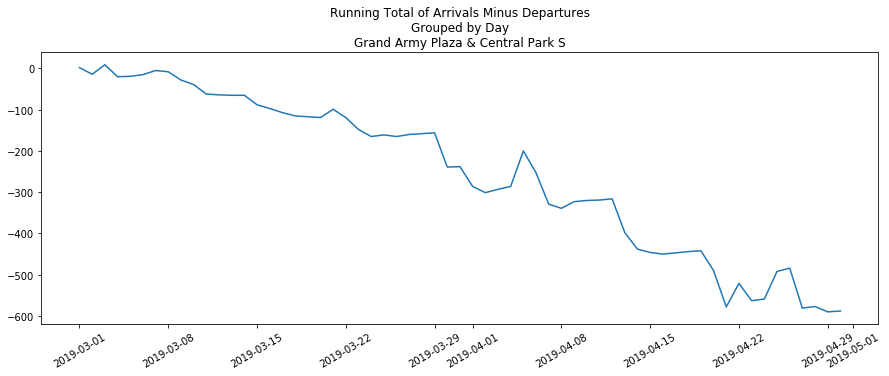

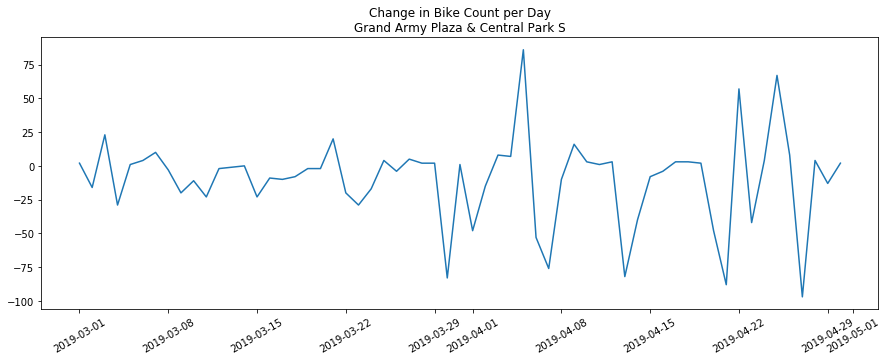

In [50]:
auto_arima_fitting_and_results(station_id = 281, 
                          df = df_main,
                          first_testing_date = '2019-05-01',
                          plot_timeseries = True, 
                          print_adf = False, 
                          plot_acf_pacf = False, 
                          fit_with_auto_arima = False,     
                          print_model_summary = False,
                          validation = False, 
                          multiple_day_forecast = False,
                          one_day_forecast = False,
                          return_forecasts = False)

These two plots inform us about the change in bike count per day at Station 281. The first is the running total since the begining of the training period, and the second is the change in bike count per day (the arrivals minus departures each day). As one would expect, when grouping by day the running total has less detail than it does when viewing it continuously. The second plot shows the change in bike count per day. This is the time series we will be predicting. It looks as though there may be some vague pattern in the data, but nothing obvious. Let's use auto_arima to find the best seasonal ARIMA model. 

Argument for daily timestep:
We could have chosen to group by hour, quarter day, half day, or any other subset of a day. While there is nothing wrong with using these timesteps, there are some strong benefits to grouping by day. Mainly, we can take advantage of the weekly periodicity in our time series. When using seasonal ARIMA models we include a season: a duration of time over which we expect our series to repeat. When grouping by day we can use seven timesteps as a season (seven days in a week). This is extremely beneficial to our model. If we were to use a timestep of less than a day, we would want to use a day as our season. This would keep us from informing our models of the weekly periodicity. We are also interested in predicting the change in bikes over the course of 24 hours. Using a timestep of one day will keep things more straight forward with regards to this. Of course, the other time steps would be worth trying in a continuation of this project. 

Analyzing Station 281
Grand Army Plaza & Central Park S

Stationary test for arrivals minus departures per day
at Grand Army Plaza & Central Park S
ADF Statistic: -6.755089
p-value: 0.000000


Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=600.897, BIC=605.119, Fit time=0.009 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=592.430, BIC=600.874, Fit time=0.102 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=596.769, BIC=605.213, Fit time=0.110 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=602.555, BIC=608.888, Fit time=0.045 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=588.252, BIC=598.806, Fit time=0.193 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 7); AIC=590.199, BIC=602.864, Fit time=0.468 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=590.135, BIC=598.578, Fit time=0.160 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=588.345, BIC

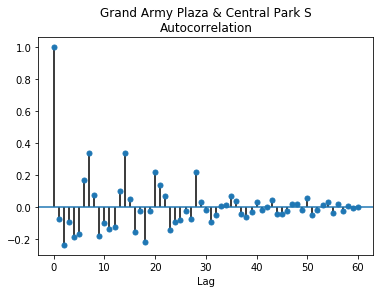

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


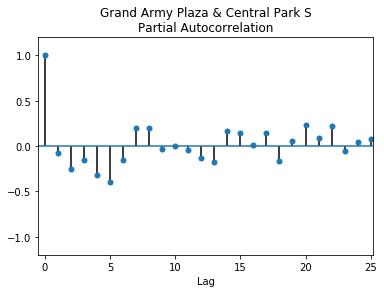

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


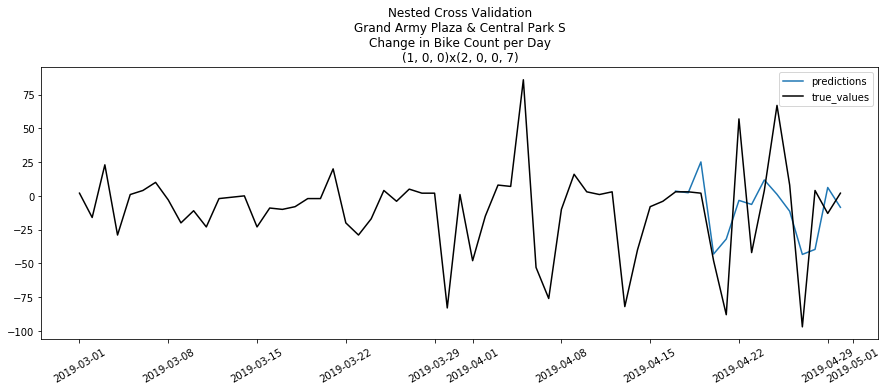

Root Mean Squared Error: 36.50 bikes
Mean Absolute Error: 28.67 bikes
                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   61
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood                -289.879
Date:                           Thu, 20 Jun 2019   AIC                            587.759
Time:                                   17:02:27   BIC                            596.202
Sample:                               03-01-2019   HQIC                           591.068
                                    - 04-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2514      0.161     -1.560      0.1

In [46]:
auto_arima_fitting_and_results(station_id = 281, 
                          df = df_main,
                          first_testing_date = '2019-05-01',
                          plot_timeseries = False, 
                          print_adf = True, 
                          plot_acf_pacf = True, 
                          fit_with_auto_arima = True,     
                          print_model_summary = True,
                          validation = True, 
                          multiple_day_forecast = False,
                          one_day_forecast = False,
                          return_forecasts = False)

This function has given us a lot of information, so let's look at each piece. First, we have the Augmented Dickey–Fuller test. This is a test to evaluate whether or not our time series is stationary. It has returned a p-value of approximately zero, thus we can feel confident that our time series is in fact stationary. 

The auto_arima function has tried several different models with many different orders and has found that a model with an order of (1, 0, 0) and a seasonal order of (2, 0, 0, 7) is best. The "1" in the model's order tells us that we have one autoregressive component (e.g. yesterday's change in bike count multiplied by some constant informs us of today's expected change in bike count). We also have two seasonal autoregressive components (i.e. this week's values depend on the values of last week and the week before that). If there were a 1 in the last position say (0, 0, 1) then we would have a moving average term in our model (e.g. today's value depends on the error in prediction of yesterday's value). 

The autocorrelation and partial autocorrelation plots can help us to determine the order of our ARIMA model. However when seasonality is present, assessing these plots to determine the order of our model becomes much more difficult. We can certainly see the seasonality in the autocorrelation plot when we lag our timeseries by  multiples of seven. The original series and lag 7 series are highly correlated. 

Our nested cross validation shows that our model does not do a great job of predicting the last two weeks of April. To repeat, we are only predicting one day out and then retraining our model to predict the next day. Thus, all those predictions are only one day out. Unfortunately, our timeseries does fluctuate pretty wildly and our model is not predicting those larger fluctuations. We have a Root Mean Squared Error (RMSE) of 36.50 bikes, which is obviously not very good. We don't want to be off by 36 bikes on average. When using the Mean Absolute Error (MAE) we have a slightly better result: 29 bikes. The MAE metric is more resilient to larger errors. Still, we certainly don't want to be off by this many bikes. This station has 61 bikes total. So this error is a significant fraction of the station's capacity

The Statespace Model Results summary gives us the model's parameter values and their importances. There is a lot of information here. What is relevant for us is the p-value associated with our parameters. For instance, our autoregressive parameter (ar.L1) has a p-value of 0.119. A p-value higher than 0.05 informs us that that parameter may not be necessary because that coefficient may be zero, meaning it would have no contribution to our model. Let's try a model with order (0, 0, 0)x(2, 0, 0, 7) and a model with order (2, 0, 0)x(2, 0, 0, 7). Both of these models earned low (good) AIC scores during auto_arima's fitting. 

Analyzing Station 281
Grand Army Plaza & Central Park S
order=(2, 0, 0), seasonal_order=(2, 0, 0, 7)


/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


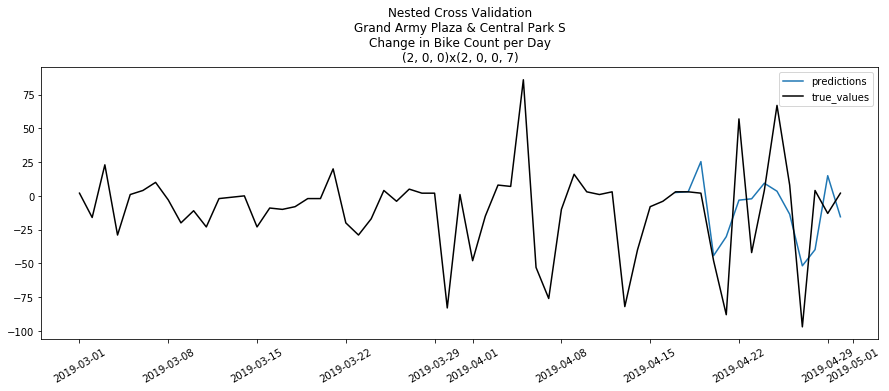

Root Mean Squared Error: 36.54 bikes
Mean Absolute Error: 29.32 bikes
Analyzing Station 281
Grand Army Plaza & Central Park S
order=(0, 0, 0), seasonal_order=(2, 0, 0, 7)


/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


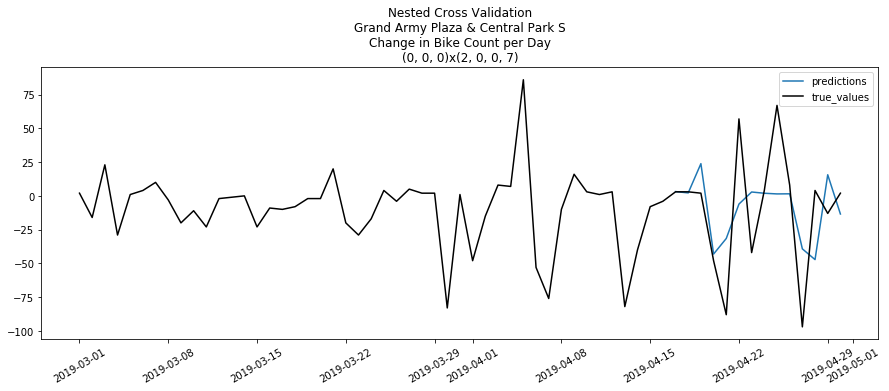

Root Mean Squared Error: 38.76 bikes
Mean Absolute Error: 29.94 bikes


In [47]:
#order=(2, 0, 0) seasonal_order=(2, 0, 0, 7)
arima_fitting_and_results(station_id=281, 
              df = df_main,
              order_ = (2,0,0), 
              seasonal_order_ = (2,0,0,7), 
              first_testing_date='2019-05-01',
              print_model_summary=False,
              validation=True,
              one_day_forecast=False,
              multiple_day_forecast=False,
              return_forecasts = False)

#order=(0, 0, 0) seasonal_order=(2, 0, 0, 7)
arima_fitting_and_results(station_id=281, 
              df = df_main,
              order_ = (0,0,0), 
              seasonal_order_ = (2,0,0,7), 
              first_testing_date='2019-05-01',
              print_model_summary=False,
              validation=True,
              one_day_forecast=False,
              multiple_day_forecast=False,
              return_forecasts = False)

As we can see neither of these models fit the data much better than auto_arima's original choice. Both the RMSE and MAE are slightly worse. Let's just stick with auto_arima's original model.

### Station 281: SARIMA Model Order (1, 0, 0)x(2, 0, 0, 7).

### Evaluating Station 3263: Cooper Square & Astor Pl

Analyzing Station 3263
Cooper Square & Astor Pl


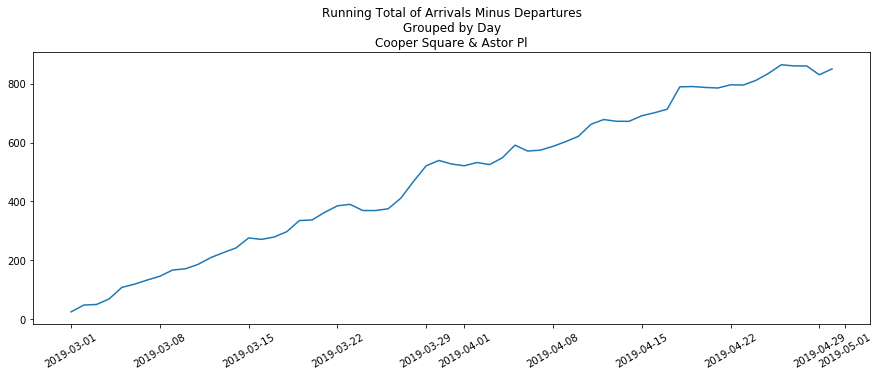

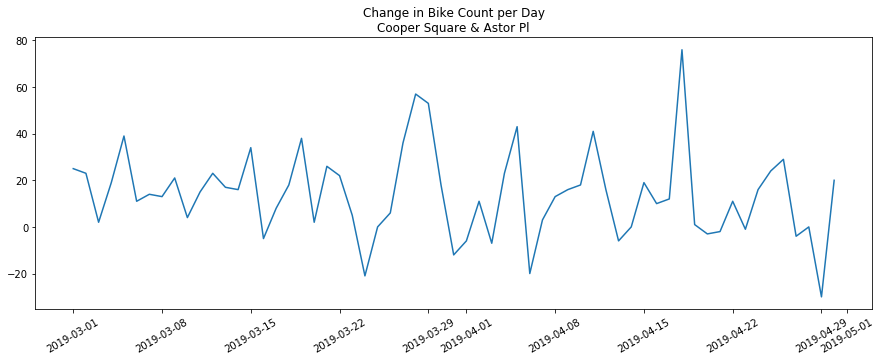

In [51]:
auto_arima_fitting_and_results(station_id = 3263, 
                          df = df_main,
                          first_testing_date = '2019-05-01',
                          plot_timeseries = True, 
                          print_adf = False, 
                          plot_acf_pacf = False, 
                          fit_with_auto_arima = False,     
                          print_model_summary = False,
                          validation = False, 
                          multiple_day_forecast = False,
                          one_day_forecast = False,
                          return_forecasts = False)

Does this station at Cooper Square & Astor Pl have a more predictable change time series? It's hard to tell. The "Change in Bike Count per Day" plot seems to have some regularity to it. Let's see what auto_arima chooses as the most apt model. 

Analyzing Station 3263
Cooper Square & Astor Pl

Stationary test for arrivals minus departures per day
at Cooper Square & Astor Pl
ADF Statistic: -7.270633
p-value: 0.000000


Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=533.898, BIC=538.120, Fit time=0.007 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=527.351, BIC=535.795, Fit time=0.085 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=529.829, BIC=538.273, Fit time=0.090 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=534.355, BIC=540.688, Fit time=0.038 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=526.926, BIC=537.480, Fit time=0.169 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 7); AIC=526.553, BIC=539.219, Fit time=0.405 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 7); AIC=524.664, BIC=535.218, Fit time=0.342 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(2, 0, 1, 7); AIC=526.553, BIC=539.218, Fit tim

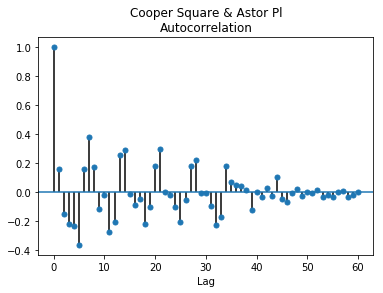

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


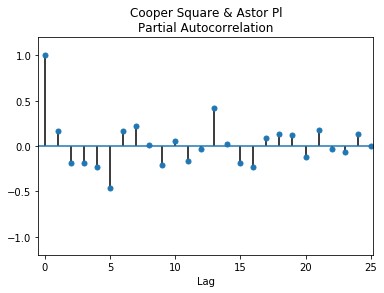

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


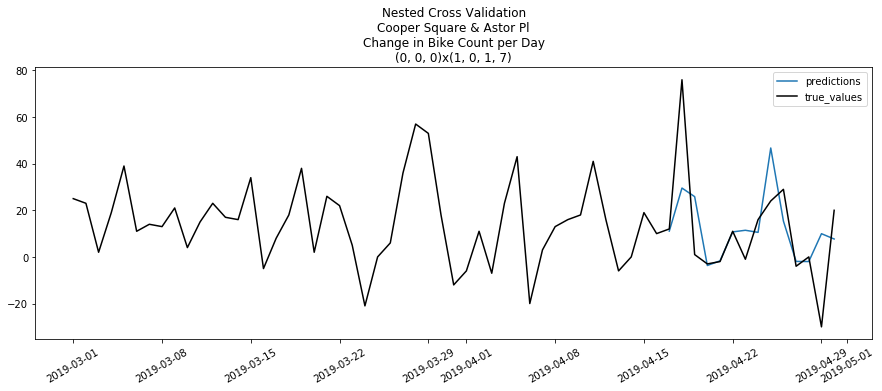

Root Mean Squared Error: 19.68 bikes
Mean Absolute Error: 13.15 bikes
                            Statespace Model Results                           
Dep. Variable:                       y   No. Observations:                   61
Model:             SARIMAX(1, 0, 1, 7)   Log Likelihood                -260.567
Date:                 Thu, 20 Jun 2019   AIC                            527.134
Time:                         17:59:28   BIC                            533.467
Sample:                     03-01-2019   HQIC                           529.616
                          - 04-30-2019                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9591      0.066     14.555      0.000       0.830       1.088
ma.S.L7       -0.6746      0.238     -2.829      0.00

In [53]:
auto_arima_fitting_and_results(station_id = 3263, 
                          df = df_main,
                          first_testing_date = '2019-05-01',
                          plot_timeseries = False, 
                          print_adf = True, 
                          plot_acf_pacf = True, 
                          fit_with_auto_arima = True,     
                          print_model_summary = True,
                          validation = True, 
                          multiple_day_forecast = False,
                          one_day_forecast = False,
                          return_forecasts = False)

Again, the ADF test ensures us that we have a stationary time series for this Citi Bike station. We also see a strong weekly periodicity in the autocorrelation plot. The partial autocorrelation plot does not give us much insight once again. The auto_arima function found that the model with order and seasonal order of (0, 0, 0)x(1, 0, 1, 7) has the lowest AIC. Thus, this model does not include any information given by the value at the previous time step. There is no relation between today's value and yesterday's. We see this via the (0, 0, 0) non-seasonal order. Instead, this model is very interested in the relationship between one week's values and it's preceding week's. The weekly autoregressive term tells us that this week's predictions are some multiple of the previous week's values, and the error in the previous week's values informs us about this weeks values. The nested cross validation does seem to follow the trend in the training data well. We have smaller RMSE and MAE values in the model, which is good, but we must realize that this station simply doesn't experience as large a range in values as the previous station. Thus, the smaller error in prediction is to be expected. Also, in the 'Statespace Model Results' summary we see that the small p-values for these parameters informs us that these parameters are significant and our model is appropriate. Still, let's try the two models which auto_arima found to have the 2nd and 3rd lowest AIC - (1, 0, 0) and (0, 0, 1) with the same seasonal order (1, 0, 1, 7).

Analyzing Station 3263
Cooper Square & Astor Pl
order=(1, 0, 0), seasonal_order=(1, 0, 1, 7)


/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


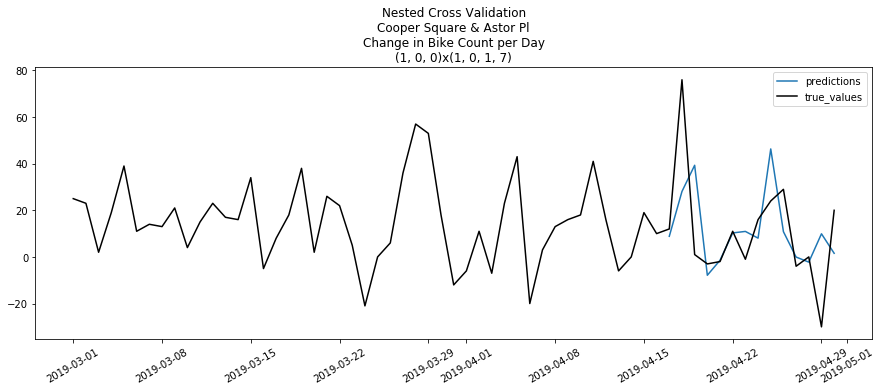

Root Mean Squared Error: 22.02 bikes
Mean Absolute Error: 15.75 bikes
                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   61
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 7)   Log Likelihood                -260.316
Date:                           Thu, 20 Jun 2019   AIC                            528.632
Time:                                   18:27:21   BIC                            537.076
Sample:                               03-01-2019   HQIC                           531.941
                                    - 04-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0971      0.116      0.836      0.4

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


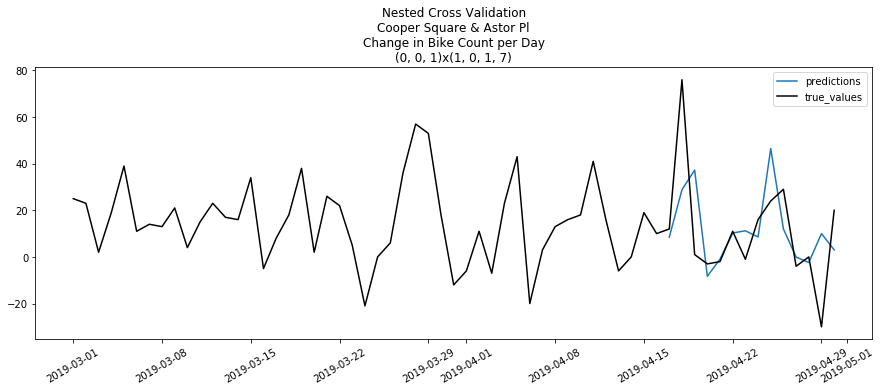

Root Mean Squared Error: 21.53 bikes
Mean Absolute Error: 15.46 bikes
                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   61
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -260.361
Date:                           Thu, 20 Jun 2019   AIC                            528.721
Time:                                   18:27:24   BIC                            537.165
Sample:                               03-01-2019   HQIC                           532.030
                                    - 04-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0796      0.120      0.666      0.5

In [56]:
#order=(1, 0, 0) seasonal_order=(1, 0, 1, 7)
arima_fitting_and_results(station_id=3263, 
              df = df_main,
              order_ = (1,0,0), 
              seasonal_order_ = (1,0,1,7), 
              first_testing_date='2019-05-01',
              print_model_summary=True,
              validation=True,
              one_day_forecast=False,
              multiple_day_forecast=False,
              return_forecasts = False)

#order=(0, 0, 1) seasonal_order=(1, 0, 1, 7)
arima_fitting_and_results(station_id=3263, 
              df = df_main,
              order_ = (0,0,1), 
              seasonal_order_ = (1,0,1,7), 
              first_testing_date='2019-05-01',
              print_model_summary=True,
              validation=True,
              one_day_forecast=False,
              multiple_day_forecast=False,
              return_forecasts = False)

Both of these models have larger errors that the model auto_arima chose as the winner. The p-values for the non-seasonal parameters are both very large as well. This informs us that these parameters are not necessary in the model. Let's once again stick with the model that auto_arima chose.

### Station 3263: SARIMA (0, 0, 0)x(1, 0, 1, 7)

## Evaluating Station 539: Metropolitian Ave & Bedford Ave

Analyzing Station 539
Metropolitan Ave & Bedford Ave


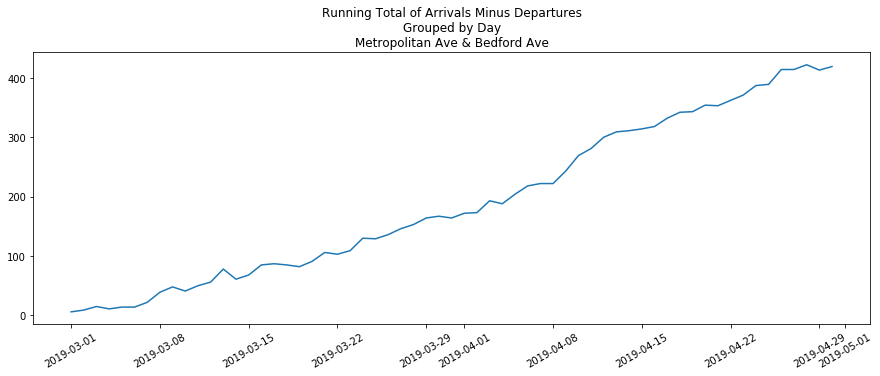

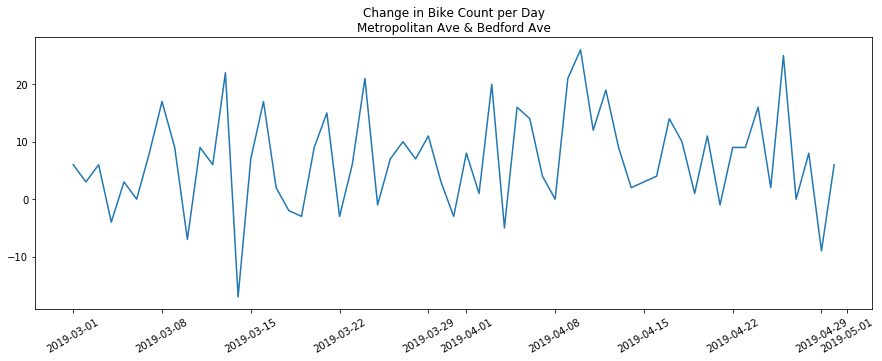

In [57]:
auto_arima_fitting_and_results(station_id = 539, 
                          df = df_main,
                          first_testing_date = '2019-05-01',
                          plot_timeseries = True, 
                          print_adf = False, 
                          plot_acf_pacf = False, 
                          fit_with_auto_arima = False,     
                          print_model_summary = False,
                          validation = False, 
                          multiple_day_forecast = False,
                          one_day_forecast = False,
                          return_forecasts = False)

This station's time series looks pretty random. Hopefully a SARIMA model can find some pattern in this. 

Analyzing Station 539
Metropolitan Ave & Bedford Ave

Stationary test for arrivals minus departures per day
at Metropolitan Ave & Bedford Ave
ADF Statistic: -8.877836
p-value: 0.000000


Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=438.415, BIC=442.637, Fit time=0.008 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=441.008, BIC=449.451, Fit time=0.076 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=440.864, BIC=449.307, Fit time=0.067 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=440.349, BIC=446.682, Fit time=0.050 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 7); AIC=440.361, BIC=446.693, Fit time=0.046 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 7); AIC=442.313, BIC=450.756, Fit time=0.106 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=439.010, BIC=445.343, Fit time=0.028 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 7); AIC=438.865, BIC=445.1

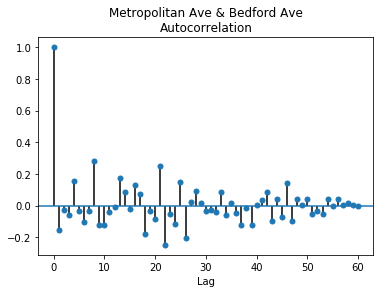

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


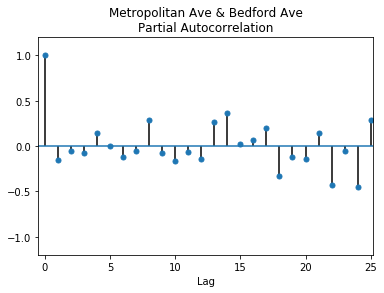

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


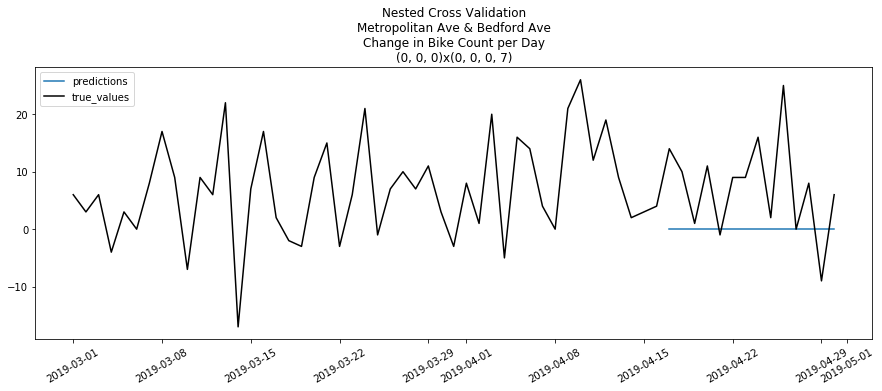

Root Mean Squared Error: 10.85 bikes
Mean Absolute Error: 8.64 bikes
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   61
Model:                        SARIMAX   Log Likelihood                -232.494
Date:                Thu, 20 Jun 2019   AIC                            466.989
Time:                        18:34:01   BIC                            469.100
Sample:                    03-01-2019   HQIC                           467.816
                         - 04-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       119.6885     23.067      5.189      0.000      74.478     164.899
Ljung-Box (Q):                       49.99   Jarque-Bera (JB):

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [58]:
auto_arima_fitting_and_results(station_id = 539, df = df_main,
                          first_testing_date = '2019-05-01',
                          plot_timeseries = False, 
                          print_adf = True, 
                          plot_acf_pacf = True, 
                          fit_with_auto_arima = True,     
                          print_model_summary = True,
                          validation = True, 
                          multiple_day_forecast = False,
                          one_day_forecast = False,
                          return_forecasts = False)

Well this station's time series is certainly random. The auto_arima function chose a white noise model as the best model (0, 0, 0)x(0, 0, 0, 7). There is no predictor of tomorrow's value. We see the straight line as the prediction in the nested cross validation. Also there is no obvious seasonality observed in the autocorrelation plot. Let's try the 2nd and 3rd place model auto_arima found - (1, 0, 0) and (0, 0, 1) with a (0, 0, 0, 7) seasonal order. 

Analyzing Station 539
Metropolitan Ave & Bedford Ave
order=(1, 0, 0), seasonal_order=(0, 0, 0, 7)


/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


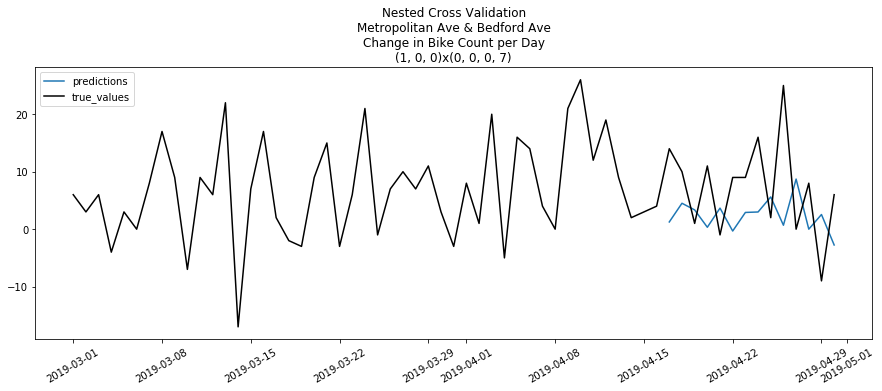

Root Mean Squared Error: 10.63 bikes
Mean Absolute Error: 9.24 bikes
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -229.691
Date:                Thu, 20 Jun 2019   AIC                            463.381
Time:                        18:46:11   BIC                            467.603
Sample:                    03-01-2019   HQIC                           465.036
                         - 04-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2953      0.120      2.465      0.014       0.061       0.530
sigma2       109.0120     21.429      5.087      0.000      67

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


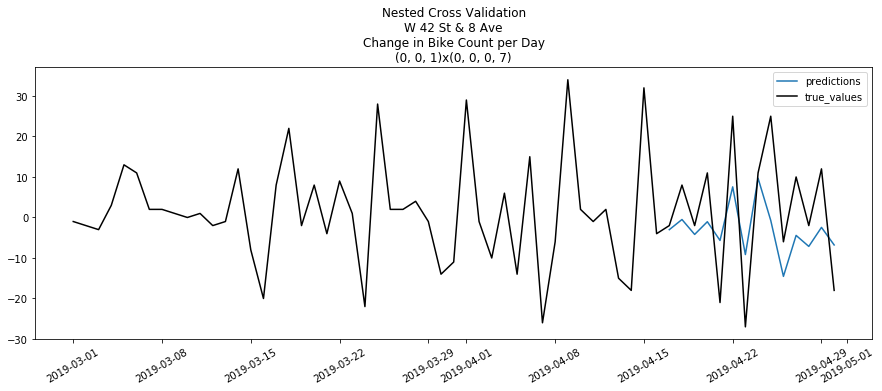

Root Mean Squared Error: 13.06 bikes
Mean Absolute Error: 11.08 bikes
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -240.635
Date:                Thu, 20 Jun 2019   AIC                            485.271
Time:                        18:46:14   BIC                            489.493
Sample:                    03-01-2019   HQIC                           486.925
                         - 04-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5050      0.122     -4.152      0.000      -0.743      -0.267
sigma2       155.5454     40.631      3.828      0.000      7

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [59]:
#order=(1, 0, 0) seasonal_order=(0, 0, 0, 7)
arima_fitting_and_results(station_id=539, 
              df = df_main,
              order_ = (1,0,0), 
              seasonal_order_ = (0,0,0,7), 
              first_testing_date='2019-05-01',
              print_model_summary=True,
              validation=True,
              one_day_forecast=False,
              multiple_day_forecast=False,
              return_forecasts = False)

#order=(0, 0, 1) seasonal_order=(0, 0, 0, 7) 
arima_fitting_and_results(station_id=529, 
              df = df_main,
              order_ = (0,0,1), 
              seasonal_order_ = (0,0,0,7), 
              first_testing_date='2019-05-01',
              print_model_summary=True,
              validation=True,
              one_day_forecast=False,
              multiple_day_forecast=False,
              return_forecasts = False)

While both of these alternative models have a lower RMSE and MAE than the original pick of auto_arima, the moving average model - the model with order (0, 0, 1) - seems to be fitting the shape of the data best. Also the moving average coefficient, ma.L1, has a p-value of 0, meaning it is very useful for our model. Let's use this as our choice of model.

### Station 529: SARIMA (0, 0, 1)x(0, 0, 0, 7)

## Time Series Model Predictions

Let's use these three models to predict the expected change in bike count per day for the first two weeks of May at these stations. We will use our models to predict the first two weeks of May one day at a time. We will predict May 1st, then retrain our model using the true value of May 1st (and all of our March and April training data) to predict May 2nd. Then retrain our model on March, April, May 1st and 2nd and predict March 3rd and so on. This is very similar to our Day Forward Nested Cross Validation process. 

We will also conduct three day forecast in a similar fashion. We will use our training day to predict May 1st, 2nd and 3rd, record those predictions, then retrain our model on March, April and May 1st, 2nd, and 3rd to predict the 4th, 5th, and 6th of May. It is the same process as before, but now we are predicting three days at a time. 

## Station 281 Predictions for May 2019

Analyzing Station 281
Grand Army Plaza & Central Park S
order=(1, 0, 0), seasonal_order=(2, 0, 0, 7)


/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


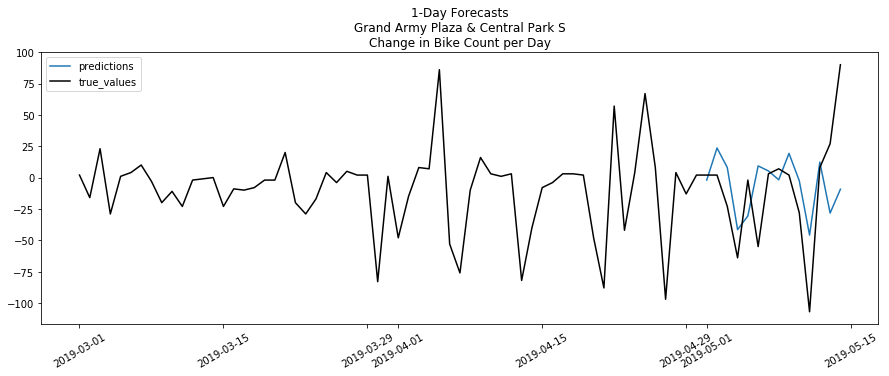

Root Mean Squared Error: 41.93 bikes
Mean Absolute Error: 31.85 bikes


/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


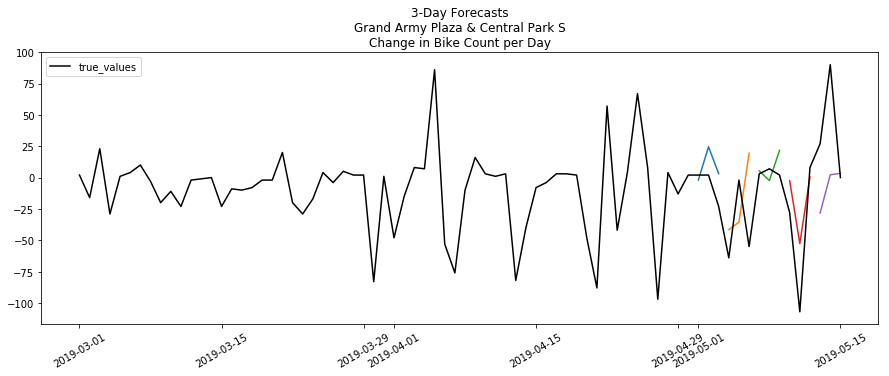

Root Mean Squared Error: 39.40 bikes
Mean Absolute Error: 29.87 bikes


In [72]:
arima_forecasts_station_281 = arima_fitting_and_results(station_id=281, 
              df = df_main,
              order_ = (1,0,0), 
              seasonal_order_ = (2,0,0,7), 
              first_testing_date='2019-05-01',
              print_model_summary=False,
              validation=False,
              one_day_forecast=True,
              multiple_day_forecast=True,
              return_forecasts = True)

Well, our predictions are once again not all that accurate. When considering one day forecasts, retraining our model after each day, our model seems to follow the general trend of May, but we still have a RMSE of 42 bikes and a MAE of 32 bikes. We would hope for better predictions but that is what our model has to offer. For some stroke of luck our three day forecasts are slightly more accurate with a RMSE of 39 bikes and a MAE of 30. The second and third predictions of one iteration of this model are based on previous predictions rather than true values. Thus, we should not expect this to be the case most of the time. This station currently (June 2019) has 61 docks at which to park a bike. Assuming the dock count was the same in May 2019, we are off by about half or two-thirds of the capacity of the dock. This is not desirable. 

Well, maybe our time series predictions for Station 3263 are more accurate. 


## Station 3263 Predictions for May 2019

Analyzing Station 3263
Cooper Square & Astor Pl
order=(0, 0, 0), seasonal_order=(1, 0, 1, 7)


/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


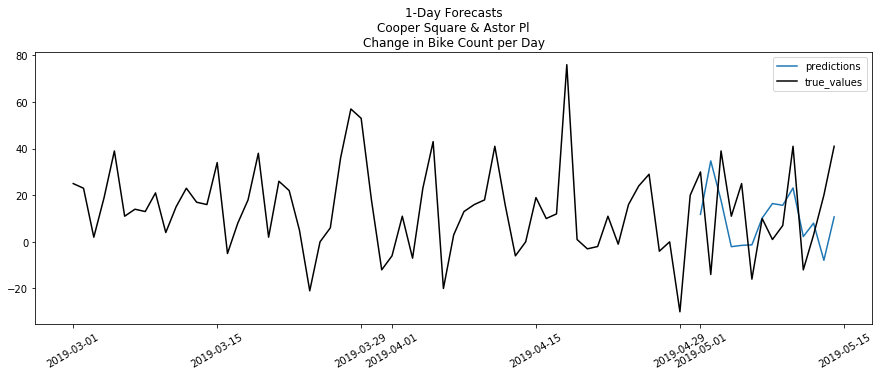

Root Mean Squared Error: 22.05 bikes
Mean Absolute Error: 18.73 bikes


/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


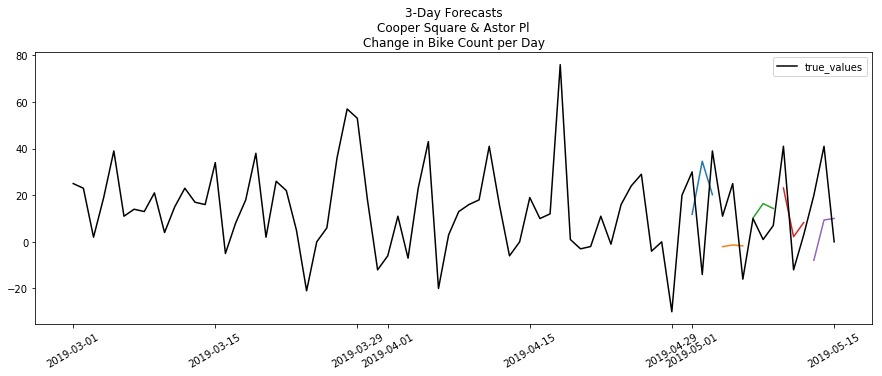

Root Mean Squared Error: 21.34 bikes
Mean Absolute Error: 17.94 bikes


In [71]:
arima_forecasts_station_3263 = arima_fitting_and_results(station_id=3263, 
              df = df_main,
              order_ = (0,0,0), 
              seasonal_order_ = (1,0,1,7), 
              first_testing_date='2019-05-01',
              print_model_summary=False,
              validation=False,
              one_day_forecast=True,
              multiple_day_forecast=True,
              return_forecasts = True)

Well we again don't have a great May 2019 forecast. We are off by roughly 20 bikes in both the RMSE and MAE in both the one day and three day predictions. This station has 58 docks, thus our predictions are in general off by about one-third of the dock. We would hope for better, but at least this is less poor of a prediction as Station 281. Again, our model looks to be fitting the general shape of May's data alright. The three day forecast is slightly more accurate than the one day forecasts once again. We, in general, would expect the opposite. Perhaps, this speaks to how difficult our data is to predict. 

## Station 539 Predictions for May 2019

Analyzing Station 539
Metropolitan Ave & Bedford Ave
order=(0, 0, 1), seasonal_order=(0, 0, 0, 7)


/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


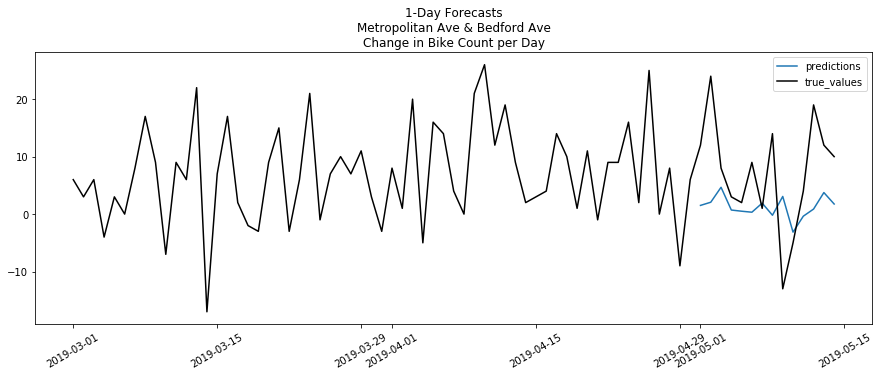

Root Mean Squared Error: 10.80 bikes
Mean Absolute Error: 8.59 bikes


/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


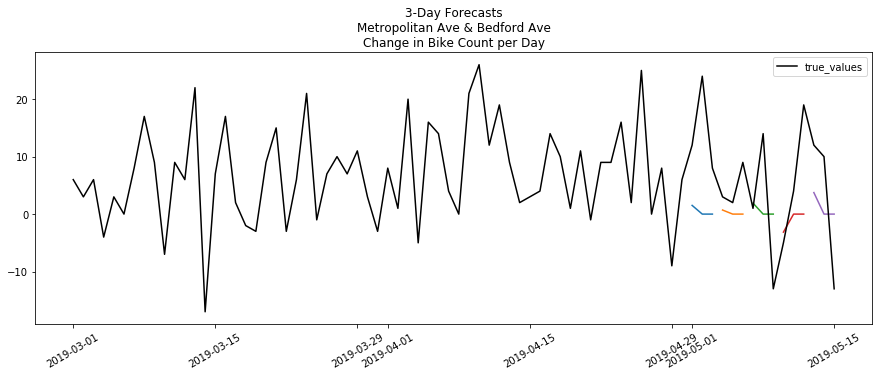

Root Mean Squared Error: 11.32 bikes
Mean Absolute Error: 9.32 bikes


In [73]:
arima_forecasts_station_539 = arima_fitting_and_results(station_id=539, 
              df = df_main,
              order_ = (0,0,1), 
              seasonal_order_ = (0,0,0,7), 
              first_testing_date='2019-05-01',
              print_model_summary=False,
              validation=False,
              one_day_forecast=True,
              multiple_day_forecast=True,
              return_forecasts = True)

Well, unfortunately, this station too has a poor prediction for May 2019. Our predictions are off by approximately 10 bikes on average. This station has 30 docks, so we are off by about one-third of the stations capacity each day. This station's daily forecasts are slightly more accurate than the three day forecasts.


## Time Series Conclusion

Well, this certainly did not work well. We tried out several SARIMA models. The auto_arima function tried many before it returned the model with the lowest AIC score, and we checked the model that the function returned against other contenders. But still, our predictions are inconsistent with observation by a significant fraction of each station's bike capacity. 

One would assume that the weather or whether the day is a weekend or weekday may affect the change in bike count over the course of a day, yet we have not included any of this information. Let's now treat this problem as a regression problem and see if the regression model performs more accurately.  



# Regression Analysis

We will now treat this problem as a regression analysis so that we may compare its results to that of the SARIMA models. This very different approach to the problem will hopefully yield better results. 

#### Target Variable
The target variable of each analysis is the change in bike count per day for the station we are analyzing. 

#### Feature Selection 
Many of the features of this analysis will be daily weather data collected by the John F. Kennedy Airport in New York, New York. One would expect the weather to have a significant impact on the number of trips taken. If the weather is severe we would assume there to be few to no trips taken, thus very little to no change in the number of bikes at a station. The features will be: 'average_wind' in units of miles per hour, 'precipitation', 'snowfall' and 'snow_depth' all in units of inches, and 'average_temp', 'max_temp' and min_temp' expressed in degrees fahrenheit. To be transparent, these last three features refer to the daily average temperature, minumum temperature, and maximum temperature. This data can be found at https://www.ncdc.noaa.gov/cdo-web/search

We will also include if the day is a weekend or holiday. It seems likely that some stations are busier on weekends and others on weekdays. Thus, this seems like an appropriate feature. This feature will be named 'weekend_holiday' and be a 0 for a weekday and 1 for a weekend or holiday. We will consider holidays days which U.S. Banks observed as holidays. This list can be found at https://banks.org/bank-holiday-schedule-for-2017-and-2018/

Also, the time of year seems to be an appropriate feature. We will use the month as a feature because of this.

We will also use the year as a feature. Since we have no concern about a stationary time series, we may use as much data as we would like to train our model. When performing time series analysis on the stations, we could only include a few months because with too much data our time series would veer from being stationary. Certain stations behaved differently in different years, thus this seems like a reasonable feature. We will include data from January 1st 2017 onward. 


### Data Wrangling

In [76]:
################################################################################
# creating dataframe to finally be joined with a given station's change in bike 
# count data 
df_daily_conditions = pd.read_csv('jfk_weather_data.csv')[['DATE', 'AWND', 'PRCP',
                'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN']]

# renaming columns
df_daily_conditions = df_daily_conditions.rename({'DATE':'date',
               'AWND':'average_wind',
               'PRCP':'precipitation', 
               'SNOW':'snowfall',
               'SNWD':'snow_depth',
               'TAVG':'average_temp',
               'TMAX':'temp_max',
               'TMIN':'temp_min'}, axis=1).copy()

# determining which days are weekends
df_daily_conditions['date'] = pd.to_datetime(df_daily_conditions['date'])
df_daily_conditions['weekend'] = np.where((
    df_daily_conditions['date'].dt.weekday == 0) | (
    df_daily_conditions['date'].dt.weekday == 6), 1, 0)

# list of holidays
holidays = [
    '2017-01-02',
    '2017-01-20',
    '2017-02-20',
    '2017-05-29',
    '2017-07-04',
    '2017-09-04',
    '2017-10-09',
    '2017-11-11',
    '2017-11-23',
    '2017-12-25',
    '2018-01-01',
    '2018-01-15',
    '2018-02-19',
    '2018-05-28',
    '2018-07-04',
    '2018-09-03',
    '2018-10-08',
    '2018-11-12',
    '2018-11-22',
    '2018-12-25',
    '2019-01-01',
    '2019-01-21',
    '2019-02-18',
    '2019-05-27']

holidays = pd.to_datetime(pd.Series(holidays))

df_daily_conditions['holiday'] = np.where(
    df_daily_conditions.date.isin(holidays), 1, 0)

# creating a columns that indicates whether a day is a weekend/holiday or weekday
df_daily_conditions['weekend_holiday'] = np.where(
    (df_daily_conditions['holiday'] == 1) | (df_daily_conditions[
        'weekend'] == 1), 1, 0)

df_daily_conditions = df_daily_conditions.drop(
    ['weekend','holiday'], axis = 1)

# extracting the month and year from the data and creating a unique feature 
# for each month
# the month number is categorical as is the year
df_daily_conditions['month'] = df_daily_conditions['date'].dt.month
df_daily_conditions['year'] = df_daily_conditions['date'].dt.year
df_daily_conditions = pd.get_dummies(data = df_daily_conditions,
                                     columns = ['month'], prefix='month')
df_daily_conditions = pd.get_dummies(data = df_daily_conditions,
                                     columns = ['year'], prefix='year')

# reordering the features in the dataset
df_daily_conditions = df_daily_conditions[['date', 'average_wind',
       'precipitation', 'snowfall', 'snow_depth', 'average_temp', 'temp_max',
       'temp_min', 'weekend_holiday', 'year_2017', 'year_2018', 'year_2019', 
        'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']].copy()

# display dataframe
df_daily_conditions.head()

,date,average_wind,precipitation,snowfall,snow_depth,average_temp,temp_max,temp_min,weekend_holiday,year_2017,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2017-01-01,9.84,0.00,0.0,0.0,46,52.0,34.0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-02,10.07,0.31,0.0,0.0,40,43.0,34.0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-03,13.42,0.46,0.0,0.0,43,46.0,41.0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-04,17.67,0.00,0.0,0.0,46,55.0,35.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-05,17.67,0.00,0.0,0.0,34,35.0,28.0,0,1,...,0,0,0,0,0,0,0,0,0,0


In another notebook, I compiled all of Citi Bikes trip data from 2017 to 2019 and extracted the trips pertaining to our stations of interest just as I had previously. It was a lot of data for my computer to handle. I will not include the code for that here because of that. It is very similar to the code I have written before. I exported that data as a csv and will import it here. 

In [186]:
# uploading previously created dataframes with our stations' 
# data for each day from 2017-01-01 to 2019-05-31
station_change_per_day_281 = pd.read_csv('station_daily_281.csv')
station_change_per_day_3263 = pd.read_csv('station_daily_3263.csv')
station_change_per_day_539 = pd.read_csv('station_daily_539.csv')

# making a list of the df's
station_change_per_day_list = [station_change_per_day_281, 
                               station_change_per_day_3263,
                               station_change_per_day_539]

# Dropping unnecessary colomns
for index, frame in enumerate(station_change_per_day_list):
    station_change_per_day_list[index] = frame.drop(
        ['year', 'month', 'day', 'Unnamed: 0', 'total_change'], axis=1)
print('station_change_per_day_281')
station_change_per_day_list[2].head()


station_change_per_day_281


,change_per_day,date
0,8,2017-01-01
1,3,2017-01-02
2,-8,2017-01-03
3,6,2017-01-04
4,5,2017-01-05


Below is our function that will perform the regression analysis. It requires the station's dataframe shown above, and will return plots and predictions if corresponding parameters are set to true. To be clear, the station's dataframe shown above (e.g. 'station_change_per_day_281') will be joined with df_daily_conditions, and then regression analysis will be performed. 

In [241]:
################################################################################
def station_regression_analysis(frame, 
                               correlation_heatmap,
                               random_forest_,
                               plot_feature_importance,
                               KNN_,
                               return_y_pred_list):
    """
    Performs regression analysis on a stations data. The target is the change
    in bike count per day, and the features are given by df_daily_conditions 
    which in this function we will join with the data frame of the station.
    
    Parameters:
    frame (pandas dataframe): Pandas dataframe with a stations change in bike count 
                            data. 'change_per_day' and 'date' are the columns.
    correlation_heatmap (Boolean): if True, plots a correlation heatmap of the
                                features.
    random_forest_ (Boolean): if True, performs Random Forest regression analysis
    KNN_ (Boolean): if Tree, performs KNN regression analysis
    return_y_pred_list (Boolean): if True, returns list of predicitons
    
    Returns:
    (list of lists): A list with two elements. The first is a list of the 
                    Random Forest prediction, and the second is a list
                    of the KNN predictions
    
    """

    # Joining dataframe contrain station's arrivals minus departures and 
    # dataframe containing daily conditions (weather, weekend, etc.)
    df_regr = frame.set_index('date').join(
        df_daily_conditions.set_index('date')).reset_index()

    # Splitting dataframe into training and testing. We will be testing 
    # on May 2019 only.
    # This allows us to compart to the the time series models which tested 
    # on May 2019
    df_regr_train = df_regr[
        (df_regr['date'] >= '2017-01-01') & (df_regr['date'] < '2019-05-01')]
    df_regr_test = df_regr[df_regr['date'] >= '2019-05-01']
    
    X_train = df_regr_train.drop(['date', 'change_per_day'], axis=1)
    y_train = df_regr_train['change_per_day']
    
    X_test = df_regr_test.drop(['date', 'change_per_day'], axis=1)
    y_test = df_regr_test['change_per_day']
    
    if correlation_heatmap == True:
        # correlation heatmap
        plt.figure(figsize=(11,10))
        sns.heatmap(df_regr_train.corr())
        plt.show()


    # Random Forest Regression
    

    if random_forest_ == True:
        # parameter to try in GridSearchCV
        parameters = [{'n_estimators':[10,30,50,70,100,200,300,400,500],
                       'min_samples_leaf':[1,3,5]}]

        rf = RandomForestRegressor(random_state=0)
        rf_grid = GridSearchCV(rf, parameters, cv=5,
                               scoring='neg_mean_squared_error')
        rf_grid.fit(X_train, y_train)
        print('Random Forest Regession Results')
        print('Parameters which achieved the highest' +
              'negated mean squared score:\n{}'.format(
            rf_grid.best_params_))
        print('Mean cross validation root mean squared error score: {}'.format(
            np.sqrt(np.abs(rf_grid.best_score_))))


        # use best estimator found via r2 score
        regr = rf_grid.best_estimator_

                
        # Best Random Forest model's Predicted Values
        y_pred = regr.predict(X_test)
        
        # plotting the predictions
        plt.title('Random Forest Predictions')
        plt.plot(df_regr_test.date, y_pred)
        plt.plot(df_regr_test.date, y_test)
        plt.xticks(rotation = -60)
        plt.legend(['y_pred','y_test'])
        plt.show()


        # Comparing to test data
        print('Root Mean Squared Error score: {}'.format(
            round(np.sqrt(mean_squared_error(y_test, y_pred)),3)))
        print('Mean Absolute Error score: {}'.format(
            round(mean_absolute_error(y_test, y_pred)),3))
        print('R^2 score: {}'.format(
            r2_score(y_test, y_pred)))

        if plot_feature_importance == True:
            # plotting feature importance
            regr.fit(X_train, y_train)
            plt.figure(figsize= (12,5))
            plt.bar(x = X_train.columns, height = regr.feature_importances_)
            plt.xticks(rotation = -60)
            plt.title('Feature Importance\nRandom Forest')
            plt.show()
    
        y_pred_rf = y_pred
        

    if KNN_ == True:

        parameters = {'n_neighbors':[5,10,20,50,100,200,300],
                      'weights':['uniform','distance']}
        knn = KNeighborsRegressor(parameters)
        knn_grid = GridSearchCV(knn, parameters, cv=5,
                                scoring='neg_mean_squared_error')
        
        X_train_scaled = X_train
        knn_grid.fit(X_train_scaled, y_train)
        print('\n\nKNN Regession Results')
        print('Parameters which achieved the highest' +
              'negated mean squared score:\n{}'.format(
            knn_grid.best_params_))
        print('Mean cross validation root mean squared error score: {}'.format(
            np.sqrt(np.abs(knn_grid.best_score_))))
        knn_regr = knn_grid.best_estimator_

        knn_regr.fit(X_train_scaled, y_train)
        
        # predicting on testing data

        y_pred = knn_regr.predict(X_test)


        
        plt.title('KNN Predictions')
        plt.plot(df_regr_test.date, y_pred)
        plt.plot(df_regr_test.date, y_test)
        plt.xticks(rotation = -60)
        plt.legend(['y_pred','y_test'])
        plt.show()
        
        print('Root Mean Squared Error score: {}'.format(
            round(np.sqrt(mean_squared_error(y_test, y_pred)),3)))
        print('Mean Absolute Error score: {}'.format(
            round(mean_absolute_error(y_test, y_pred)),3))
        print('R^2 score: {}'.format(
            r2_score(y_test, y_pred)))

        y_pred_knn = y_pred
    
    if return_y_pred_list == True:
        return [y_pred_rf, y_pred_knn]

## Station 281 Regression Analysis

Let's look to see if there are any notable correlations in our features by inspecting the correlation table for Station 281, shown as a heatmap.

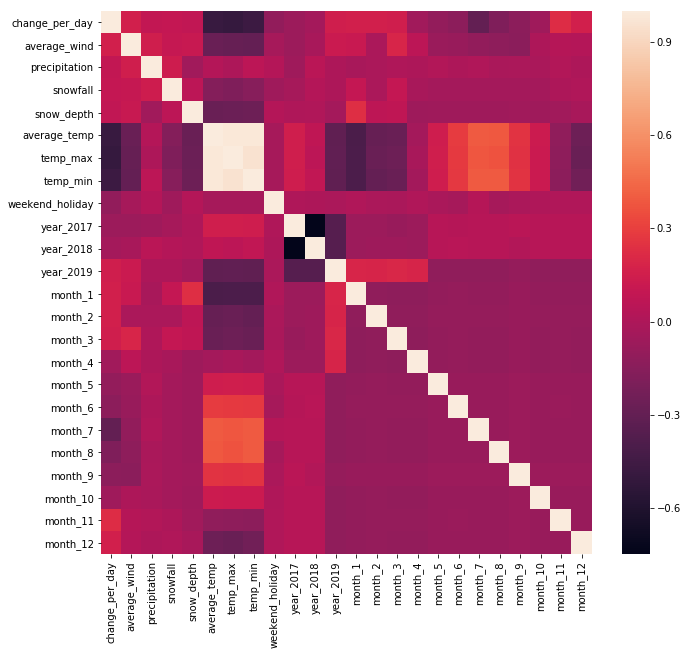

In [237]:
y_pred_regr_281 = station_regression_analysis(station_change_per_day_list[0],
                                           correlation_heatmap = True,
                                           random_forest_ = False,
                                           plot_feature_importance = False,
                                           KNN_ = False,
                                           return_y_pred_list = False)

We see some obvious weather phenomena. For instance, the temperature is high in the summer and low in the winter. A few of our variables are very highly correlated. The three temperature measures are correlated with each other because the max, average and minimum temperature for a given day will be high on a hot day and low on a cold day. We will not remove any of these temperature features because each may be telling of our target variable. Also the years 2017 and 2018 are very negatively correlated, since if it is 2017 one day, it is not 2018. We also have fewer 2019 testing days thus the asymmetry with that year.

How is our target variable 'change_per_day' correlated with the features? It seems to correlate differently with the different months, as one may expect. It also seems to be negatively correlated with the temperatures. If the temperature is low, there is a higher value in the change in bikes per day. This makes sense since Station 281 has a bike deficit issue. People take bikes from this station more often than they bring bikes to the station. Thus, we expect a less negative change in bike count when the temperature is low.

Let's perform a random forest regression and a KNN regression to see how well we can predict the testing data - the month of May 2019. Note that because we have more data, I have decided to predict the full month of May rather than the first two weeks. When finally comparing regression to time series, we will only include the first two weeks of May 2019. 

We will be using Sci-kit Learn's GridSearchCV to find the model with the lowest mean squared error score when doing 5 fold cross validation on our training data. Sci-kit learn uses a negated mean squared error score when performing cross validation because it requires that a larger score is better. So the usual MSE is multiplied by a minus sign.

Random Forest Regession Results
Parameters which achieved the highest negated mean squared score:
{'min_samples_leaf': 5, 'n_estimators': 500}
Mean cross validation root mean squared error score: 42.32993454096333


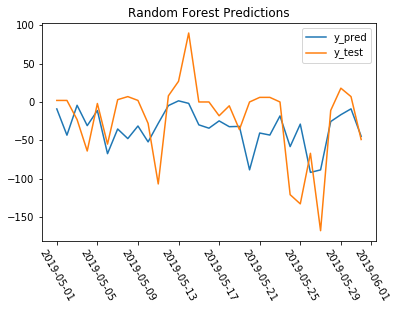

Root Mean Squared Error score: 45.623
Mean Absolute Error score: 37.0
R^2 score: 0.2158714951018309


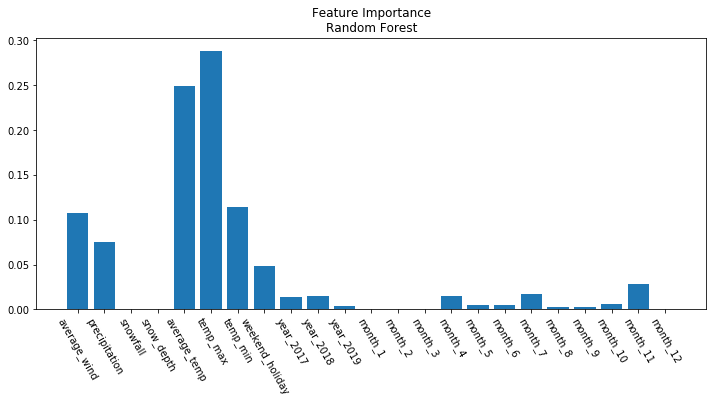

KNN Regession Results


Parameters which achieved the highest negated mean squared score:
{'n_neighbors': 100, 'weights': 'distance'}
Mean cross validation root mean squared error score: 43.19832343480384


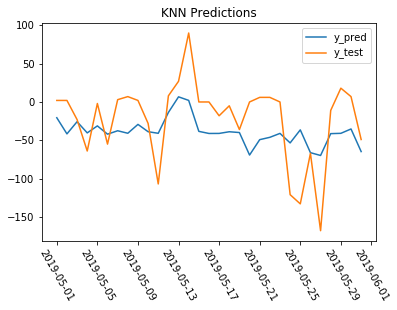

Root Mean Squared Error score: 47.206
Mean Absolute Error score: 40.0
R^2 score: 0.1605173721362304


In [238]:
y_pred_regr_281 = station_regression_analysis(station_change_per_day_list[0],
                                           correlation_heatmap = False,
                                           random_forest_ = True,
                                           plot_feature_importance = True,
                                           KNN_ = True,
                                           return_y_pred_list = True)

### Station 281 Evaluation and Comparison to ARIMA model

Well neither of these regression models worked very well. We have a RMSE score of roughly 46 bikes for random forest and 47 bikes for KNN. The MAE scores are less, as usual, and the random forest is best with an error of 37 bikes. The R-squared scores inform us that our random forest model explains roughly 20% of the variance in the target values and the KNN model explains 16%. This is not great. Because or model is not performing very well we should take the random forest feature importances with a grain of salt. It seems reasonable that the maximum temperature for a day could be the feature with most importance when determining the change in bike count at our station. 

Let's compare these models to the seasonal ARIMA model forecasts we previously calculated.

In [249]:
def compare_regression_and_arima(station_change_per_day_df, 
                                station_arima_forecasts,
                                y_pred_regr,
                                station_number):
    """
    Plots the varying models' predictions against the testing data.
    Also prints the RMSE and MAE of each model's predictions.
    This function does not return anything
    
    Parameters:
    station_change_per_day_df (Pandas Dataframe): Dataframe with describing
            the bike count change for a given day at the specified station.
    station_arima_forecasts (list of lists): List of ARIMA forecast 
            predictions for station of interest. First is the 1-day forecast
            2nd is the three day forecast
    y_pred_regr (list of lists): First list is the Random Forest predictions.
            Second list is the KNN Regression Predictions
    station_number (int): The station of interests ID number
    
    """
    
    
    may_dates_list = station_change_per_day_df[
        station_change_per_day_df['date'] >= '2019-05-01']["date"]

    y_true_two_weeks = station_change_per_day_df[
        station_change_per_day_df['date'] >= '2019-05-01']['change_per_day'][:14]

    plt.figure(figsize = (12,8))
    plt.plot(may_dates_list[:14],station_arima_forecasts[0],
             label = 'SARIMA Daily Forecast')
    plt.plot(may_dates_list[:14],y_pred_regr[0][:14], label = 'Random Forest')
    plt.plot(may_dates_list[:14],y_pred_regr[1][:14], label = 'KNN')
    plt.plot(may_dates_list[:14],station_change_per_day_df[
        station_change_per_day_df['date'] >= '2019-05-01']['change_per_day'][:14],
             linewidth=5, label = 'y_true', color='black')
    plt.title('Station {} Prediction Comparison'.format(station_number))
    plt.xticks(rotation=30)
    plt.legend()
    plt.show()

    print('Root Mean Squared Error for first two weeks of May 2019')
    print('SARIMA Daily Forecast RMSE: {:.5}'.format(np.sqrt(mean_squared_error(
        station_arima_forecasts[0],
        y_true_two_weeks))))
    print('Random Forest RMSE: {:.5}'.format(np.sqrt(mean_squared_error(
        y_pred_regr[0][:14],
        y_true_two_weeks))))
    print('KNN RMSE: {:.5}'.format(np.sqrt(mean_squared_error(
        y_pred_regr[1][:14],
        y_true_two_weeks))))


    print('\nMean Absolute Error for first two weeks of May 2019')
    print('SARIMA Daily Forecast MAE: {:.5}'.format(mean_absolute_error(
        station_arima_forecasts[0],
        y_true_two_weeks)))
    print('Random Forest MAE: {:.5}'.format(mean_absolute_error(
        y_pred_regr[0][:14],
        y_true_two_weeks)))
    print('KNN MAE: {:.5}'.format(mean_absolute_error(
        y_pred_regr[1][:14],
        y_true_two_weeks)))


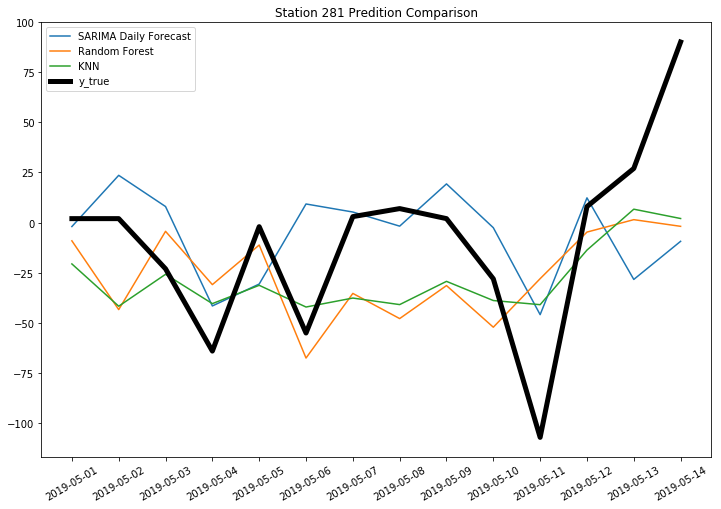

Root Mean Squared Error for first two weeks of May 2019
SARIMA Daily Forecast RMSE: 41.927
Random Forest RMSE: 42.699
KNN RMSE: 39.661

Mean Absolute Error for first two weeks of May 2019
SARIMA Daily Forecast MAE: 31.847
Random Forest MAE: 34.964
KNN MAE: 32.952


In [250]:
compare_regression_and_arima(station_change_per_day_list[0], 
                                station_arima_forecasts = arima_forecasts_station_281,
                                y_pred_regr=y_pred_regr_281,
                                station_number=281)

Well when predicting the change in bike count per day at Station 281 for the first two weeks of May 2019, no model is the clear winner. When looking at the plot the SARIMA forecast seems to follow the trajectory of the true values a bit more than the regression models, but when comparing the RMSE or MAE, no model is the clear winner. This station again has 61 docks thus our models are all generally off by two-thirds to one-half depending on the metric used. In either case, we would like to have a more reliable model. We will choose SARIMA as the winning model. Using either metric it is not the worst model, and it seems to follow the trend in the data best.

#### Station 281 winning model: SARIMA time series 

## Station 3263 Regression Analysis 

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Random Forest Regession Results
Parameters which achieved the highest negated mean squared score:
{'min_samples_leaf': 5, 'n_estimators': 300}
Mean cross validation root mean squared error score: 19.03928550486198


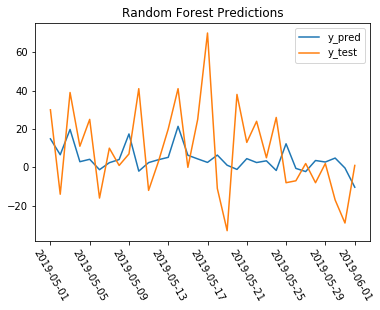

Root Mean Squared Error score: 22.297
Mean Absolute Error score: 18.0
R^2 score: 0.01752876585417429


KNN Regession Results
Parameters which achieved the highest negated mean squared score:
{'n_neighbors': 200, 'weights': 'distance'}
Mean cross validation root mean squared error score: 19.100703310319506


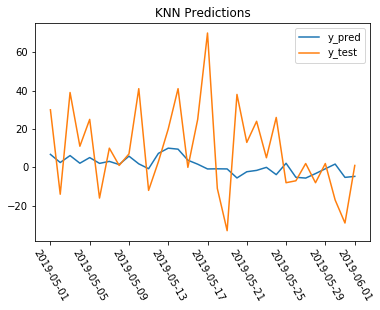

Root Mean Squared Error score: 23.096
Mean Absolute Error score: 17.0
R^2 score: -0.05420949368052064


In [242]:
y_pred_regr_3263 = station_regression_analysis(station_daily_list[1],
                                           correlation_heatmap = False,
                                           random_forest_ = True,
                                           plot_feature_importance = False,
                                           KNN_ = True,
                                           return_y_pred_list = True)

### Station 3263 Evaluation and Comparison to ARIMA model

One aspect to note is the very poor R-squared values for both of these models. Because of this, we cannot trust any feature importance analysis, thus we have left out the plot. In the case of KNN, the R-squared metric is negative, meaning it is performing worse than predicting the mean of the testing data. The random forest model just barely out performs predicting the mean of the testing data. The RMSE and MAE metrics are similar for both models. Again, this station has 58 docks so our models are inconsistant by roughly one-third of the docks capacity on average in May 2019. Let's look at how this compares to our ARIMA model for this station.

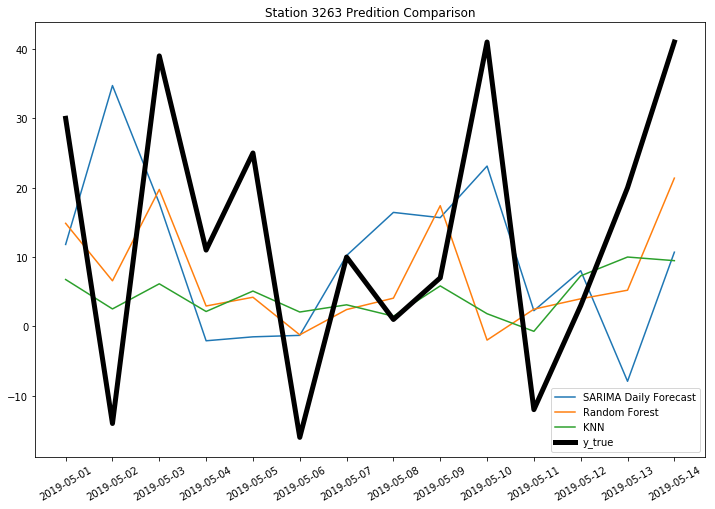

Root Mean Squared Error for first two weeks of May 2019
SARIMA Daily Forecast RMSE: 22.047
Random Forest RMSE: 18.078
KNN RMSE: 19.851

Mean Absolute Error for first two weeks of May 2019
SARIMA Daily Forecast MAE: 18.725
Random Forest MAE: 15.178
KNN MAE: 16.017


In [248]:
compare_regression_and_arima(station_change_per_day_list[1], 
                                station_arima_forecasts = arima_forecasts_station_3263,
                                y_pred_regr=y_pred_regr_3263,
                                station_number=3263)

While the SARIMA model does look to follow the trend to a slight degree, both random forest and KNN have lower RMSE and MAE scores. With 58 docks at this station, our models' average error is approximately one-third of the station's capacity. This is not as poor as Station 281's error in terms of station capacity, but it is still undesirable. We will choose Random Forest as the winning model for this station. It has the best scores when using either RMSE or MAE. 

#### Station 3263 Winning Model: Random Forest

## Station 539 Regression Analysis

/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Random Forest Regession Results
Parameters which achieved the highest negated mean squared score:
{'min_samples_leaf': 5, 'n_estimators': 500}
Mean cross validation root mean squared error score: 9.82936128597891


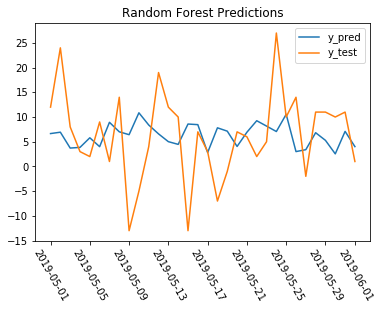

Root Mean Squared Error score: 9.479
Mean Absolute Error score: 7.0
R^2 score: -0.15067623030372168


/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)




KNN Regession Results
Parameters which achieved the highest negated mean squared score:
{'n_neighbors': 300, 'weights': 'uniform'}
Mean cross validation root mean squared error score: 9.823822015406137


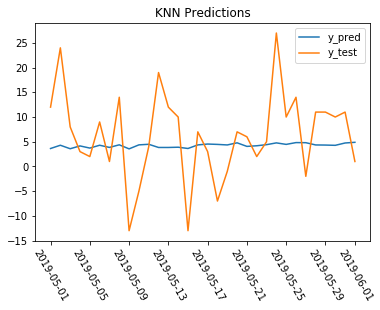

Root Mean Squared Error score: 9.0
Mean Absolute Error score: 7.0
R^2 score: -0.03728697914061341


In [251]:
y_pred_regr_539 = station_regression_analysis(station_daily_list[2],
                                           correlation_heatmap = False,
                                           random_forest_ = True,
                                           plot_feature_importance = False,
                                           KNN_ = True,
                                           return_y_pred_list = True)

### Station 539 Evaluation and Comparison to ARIMA model

These regression models are once again not very good. They both have negative R-Squared Scores meaning that using the mean of the testing data would be a better predictor. Both models have a similar RMSE and MAE score when predicting May 2019. This station has 30 docks so our average errors in prediction are roughly one-third of the docks capacity. Let's see how this compares to our chosen ARIMA model for this station.

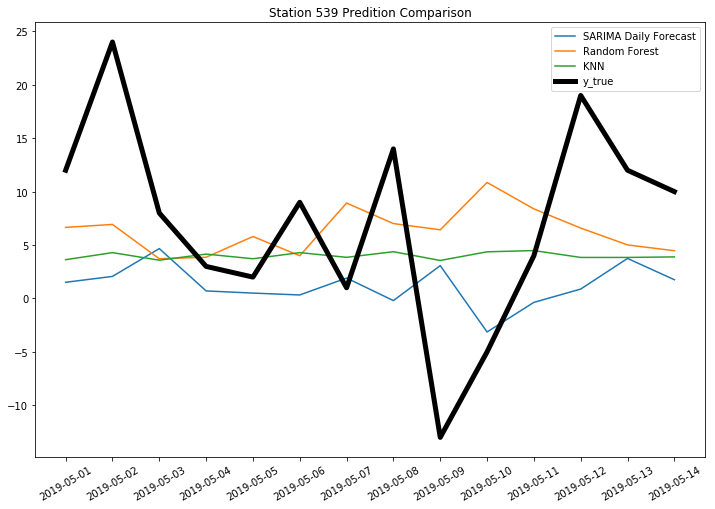

Root Mean Squared Error for first two weeks of May 2019
SARIMA Daily Forecast RMSE: 10.799
Random Forest RMSE: 9.8987
KNN RMSE: 9.6402

Mean Absolute Error for first two weeks of May 2019
SARIMA Daily Forecast MAE: 8.5888
Random Forest MAE: 8.2767
KNN MAE: 7.7419


In [252]:
compare_regression_and_arima(station_change_per_day_list[2], 
                                station_arima_forecasts = arima_forecasts_station_539,
                                y_pred_regr=y_pred_regr_539,
                                station_number=539)

Well none of the models follow the trend in the observed data very well. They are all predicting values that do not vary much. KNN has the best RMSE and MAE score. We saw that this model's R-squared score was close to zero in when predicting all of May 2019. It also does not vary much as we can see by this plot, so it much be predicting the mean of the test data well. And that is why it is our best model. All this work is unfortunately amounting to just chooing the mean, at least for this station. We will call KNN our best model for station 539. 


#### Station 539 Winning Model: KNN

# Business Impact - Informing Business Decisions

Unfortunately, none of our models are very reliable. There could be a number of reasons why, and we will discuss that in the conclusion, but for now let's assume our models are performing well so that we can demonstrate how Citi Bike could use our predictions to inform business decisions. Thus, we now have an end-to-end business solution. 

Our goal is to anticipate how many bikes will be taken from or added to a given station over a 24 hour period starting at midnight. By having a prediction of change in bike count for each station, we can inform dispatch of their expected work load. We are assuming dispatch will use a truck to rebalance the bikes at midnight when the traffic is minimal in New York City. 

If it were 12:00 AM May 1, 2019, and dispatch had just completed their rebalancing for the night, we can inform them of their expected workload in 24 hours - 12:00 AM May 2, 2019. We will assume dispatch has just finished rebalanced these stations so that they are half full. 

In [387]:
starting_at_half_full = np.array([61, 58, 31])//2
may1_expected_change = [arima_forecasts_station_281[1][0],
                        y_pred_regr_3263[0][0],
                        y_pred_regr_539[1][0]]
may2_expected_change = [arima_forecasts_station_281[1][1],
                        y_pred_regr_3263[0][1],
                        y_pred_regr_539[1][1]]
may3_expected_change = [arima_forecasts_station_281[1][2],
                        y_pred_regr_3263[0][2],
                        y_pred_regr_539[1][2]]

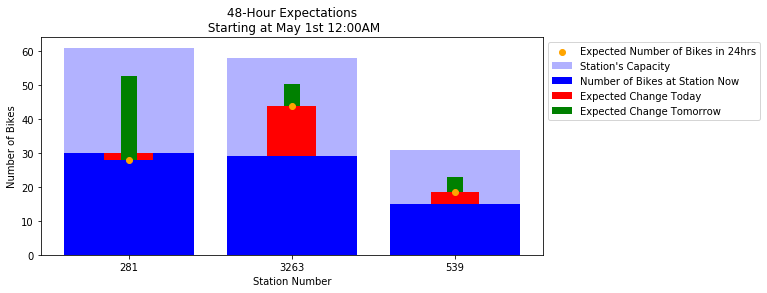

In [390]:
plt.figure(figsize=(9,4))

# Capacity
plt.bar(x = ['281', '3263', '539'],height=[61, 58, 31],
        color = 'blue', alpha = .3,
       label='Station\'s Capacity')

# Number of Bikes at Station Now
plt.bar(x = ['281', '3263', '539'],height=starting_at_half_full, color = 'blue',
       label='Number of Bikes at Station Now')

# Expected Change of Bikes at Station Today
plt.bar(x = ['281', '3263', '539'],height=may1_expected_change,
       bottom = starting_at_half_full, width = .3,
        color='red', label='Expected Change Today')

# Expected Change of Bikes at Station Tomorrow
plt.bar(x = ['281', '3263', '539'],height=may2_expected_change,
       bottom = starting_at_half_full + may1_expected_change,
        width = .1, color='green',
        label='Expected Change Tomorrow')

# Expected Number of Bikes at Starion Tomorrow
plt.scatter(x = ['281', '3263', '539'],
            y=starting_at_half_full + may1_expected_change, color='orange',
        label='Expected Number of Bikes in 24hrs', zorder=10)

plt.title('48-Hour Expectations\n Starting at May 1st 12:00AM')
plt.ylabel('Number of Bikes')
plt.xlabel('Station Number')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

This plot gives us the necessary information to inform dispatch on whether or not they will need to drive the truck and rebalance these stations 24 hours from now. 

The light blue is the stations capacity. The dark blue is the number of bikes at each station now (12:00AM May 1st). The red bar is the change in the number of bikes expected today. The orange dot is the number of bikes expected 24 hours from now (12:00AM May 2nd). The green bar is the expected change in bikes over the course of tomorrow (over the course of May 2nd). 

Information about the change in bikes expected today and tomorrow is necessary when informing dispatch if they will need to tend to that station in 24 hrs. We need to make sure that in 24 hours we have the right amount of bikes to supply our users for the following day.

In 24 hours, all three stations will be at a bike count within their capacity, and in 48 hours all three stations will still be within capacity. Thus, we anticipate that no rebalancing will need to happen in 24hrs. If these were the only three stations, we would inform dispatch that they will likely take the night off. 

Let's now assume our predictions were correct and it is midnight, 12:00AM May 2, 2019. Will dispatch need to take the truck out 24 hours from now?

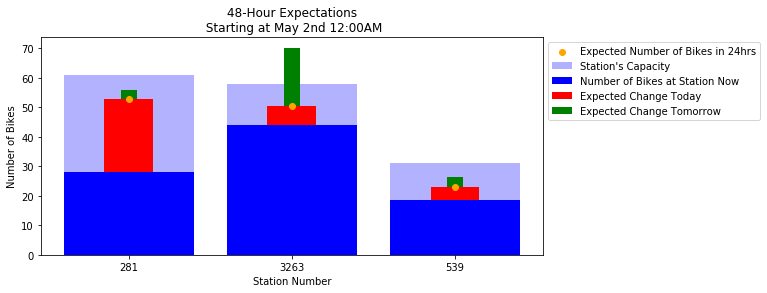

In [393]:
plt.figure(figsize=(9,4))

# Capacity
plt.bar(x = ['281', '3263', '539'],height=[61, 58, 31], color = 'blue', alpha = .3,
       label='Station\'s Capacity')

# Number of Bikes at Station Now
plt.bar(x = ['281', '3263', '539'],height=starting_at_half_full
        + may1_expected_change, color = 'blue',
       label='Number of Bikes at Station Now')

# Expected Change of Bikes at Station Today
plt.bar(x = ['281', '3263', '539'],height=may2_expected_change,
       bottom = starting_at_half_full
        + may1_expected_change, width = .3, color='red',
        label='Expected Change Today')

# Expected Change of Bikes at Station Tomorrow
plt.bar(x = ['281', '3263', '539'],height=may3_expected_change,
       bottom = starting_at_half_full + may1_expected_change
        + may2_expected_change, width = .1, color='green',
        label='Expected Change Tomorrow')

# Expected Number of Bikes at Starion Tomorrow
plt.scatter(x = ['281', '3263', '539'], y=starting_at_half_full 
            + may1_expected_change + may2_expected_change, color='orange',
        label='Expected Number of Bikes in 24hrs', zorder=10)

plt.title('48-Hour Expectations\n Starting at May 2nd 12:00AM')
plt.ylabel('Number of Bikes')
plt.xlabel('Station Number')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Will we need to rebalance bikes in 24 hours? Yes. While none of these stations will be over capacity or empty in 24 hours, we need to make room for the increase in bikes at Station 3263 that will occur during May 3rd. If we did no rebalancing, we see from the figure that Station 3263 will be over capacity in 48 hours. During May 3rd users will want to park their bike here, but have no docks to do so. Thus, we must remove roughly twenty bikes to make room for the expected increase in bikes during May 3rd. 

Lastly, it would also be informative to have a station's expected fluctuation during the day to be sure that the station has ample bikes to accommodate the users needs during the day. We have only considered the change in bike count from midnight one day to midnight the next. 

## Business Impact Conclusion

With accurate 2-day forecasts of a station's change in bike count, we can inform dispatch on which stations they will need to remove bikes and which stations they will need to add bikes. In the case of Station 3263 going over capacity, we would need to compare the cost of paying dispatch to rebalance to the potential customer dissatisfaction. Customers will be upset that they cannot dock their bike at this station, but they will likely dock their bike at another nearby station. This trade-off will need to be considered and evaluated in terms of Citi Bike's budget.

# Conclusion and Future Thoughts

It is unfortunate that our models all perform rather poorly for each of the three stations we chose to analyze. We attempted to forecast the change in bike count per day via time series forcasting and regression analysis, but neither worked well. Our time series models each have a RMSE that is a significant fraction of the stations bike capacity. The RMSE of the 1-day SARIMA forecasts for the first two weeks of May expressed as the percentage of the stations capacity are 69% for Station 281, 38% for Station 3263, and 36% for Station 539. We then attempted to use regression to help our predictions. This way we were able to include weather, day of the week and time of year. Still, this gave similarly poor results. With the inconsistant results we were still able to execute how accurate predictions would inform dispatch, thus providing and end-to-end business solution.  

### Why are our models performing so poorly? 

One of our main assumptions may be responsible for this. We are assuming that Citi Bike has rebalanced the bikes as needed. That way each trip that was taken is a reflection of the demand of the consumers. If Citi Bike leaves a station empty, no trips can start at that station, and that will affect our data. And if Citi Bike leaves a station full, no one can end their trip at this station. Our assumption that there are usually ample bikes and open docks at these stations is likely incorrect. 

We also have no information on several enviornmental factors that may affect the behavior of users. The traffic will likely affect if a customer will choose to ride a bike, and which stations they will choose to use. We do not have information on nearby events that will affect user behavior either. 

### Alternative approaches

Perhaps using a different timestep for our timeseries models would have been more helpful. I had tried using a quarter of a day at first and that was leading to even more inaccurate results. Maybe using half a day as a timestep would have worked better? We could have used 14 timesteps in a season with that approach. I would certainly try that as a next attempt at this problem.

We would also use Long Short-Term Memory recurrent neural networks and perhaps that model would out perform all the models we have tried. We could try using different time steps with the LSTM models and hopefully some would be better than these models. 

Lastly, it would be very informative to have data on the number of bikes at each dock at any given time. This would inform us of those moments when a station is full or empty. We could incorporate that into our models and have a much richer understanding of the demand of users. 

### Final Thoughts and Next Steps

While our models performed poorly we do see some regular patterns in the continuous time series shown at the beginning of this project report. Given more time, I would like to implement the alternative approaches I have mentioned to see if we can get any closer to an accurate prediction in the change in bike count per day at these stations. Maybe some other stations are more predictable. We only chose three of the roughly 800 stations Citi Bike has in operation. I would assume others are more predictable in nature. 

If we were able to model some stations accurately we could improve Citi Bike in a number of ways. As we have previously mentioned, we could inform dispatch on when they will need to rebalance bikes. We could also incentivise users to modify their trips to help with the rebalancing problem. Perhaps we could implement a rewards system where we reward users for taking a bike from a station with a surplus issue to a station with a deficit. This rebalancing issue is incredibly interesting. It is a challenge every bike sharing company will face. While these efforts did not amount to reliable models, this is still a step forward in modeling the rebalancing problem. Now, we know we must search for other methods in pursuit of a solution to this fascinating problem. 